In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from surprise.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.metrics import ndcg_score
from surprise import dump
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from surprise import SVD
import random
import pickle
from copy import deepcopy

import typing as tp
from sklearn.preprocessing import normalize
from lightfm import LightFM
from scipy.sparse import coo_matrix
from lightfm.data import Dataset as LFMDataset
from collections import Counter
from matplotlib.lines import Line2D
import time
import optuna

np.random.seed(42)

C:\ProgramData\Anaconda3\envs\torchvision\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
from uuu import mapk_plot, mapk, calculate_serendipity_per_user, prediction_coverage, \
catalog_coverage, long_tail_plot, weight_by_volume, get_frame_from_prediction_list, novelty, get_value_popularity_ranks

In [3]:
df = pd.read_csv('../data/recsys-in-practice/train_joke_df.csv')

df['UID'] = df['UID'] - 1
df['JID'] = df['JID'] - 1
# сделаем сортировку и перепишем index
df = df.sort_values(by=['UID', 'JID'])
df = df.reset_index(drop=True)

df

df_train, df_test = train_test_split(df, test_size=0.5, random_state=42)

E:\competitions\kaggle\magnit_recsys-in-practice\part2\uuu.py:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  head = head.append(tail.head(1))


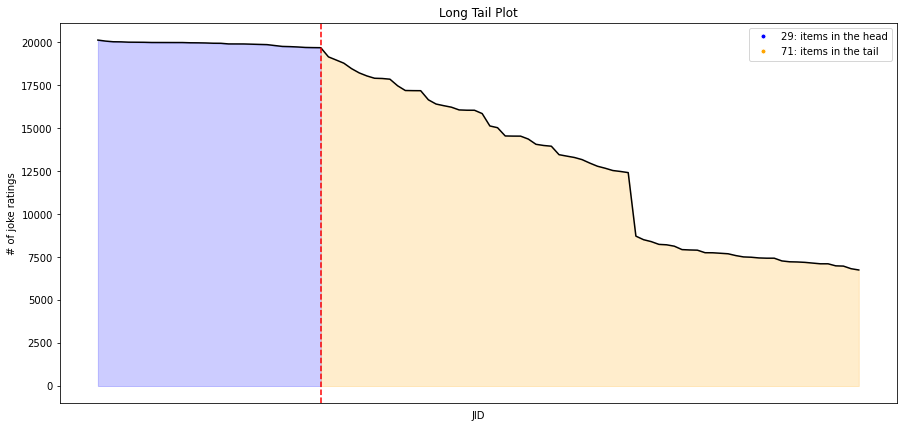

In [4]:
fig = plt.figure(figsize=(15, 7))
volume_df = long_tail_plot(df=df, 
             item_id_column="JID", 
             interaction_type="joke ratings", 
             percentage=0.4,
             x_labels=False)

volume_df['weight'] = volume_df['percent_of_total_volume'].apply(weight_by_volume)
joke_volume = {}
for row in volume_df.itertuples():
    joke_volume[int(row.JID)] = row.weight

In [5]:
df_top_joke = df[df['Rating'] > 5].groupby('JID').agg('count').rename(columns={'Rating':'count_plus'}) \
.sort_values('count_plus', ascending=False).drop(columns=['UID'])


df_bottom_joke = df[df['Rating'] < -5].groupby('JID').agg('count').rename(columns={'Rating':'count_minus'}) \
.sort_values('count_minus', ascending=False).drop(columns=['UID'])


df_counts = df_bottom_joke.merge(df_top_joke, left_index=True, right_index=True)


df_counts['diff'] = df_counts['count_plus'] - df_counts['count_minus']
df_counts = df_counts.sort_values('diff', ascending=False)


df_counts['weight'] = df_counts['diff'] / 10000

joke_quality = {}
for row in df_counts.itertuples():
    joke_quality[row.Index] = row.weight

In [6]:
with open('predictions_df_surprise.pkl', 'rb') as f:
    predictions_df_surprise = pickle.load(f)
    
predictions_df_surprise.keys()

dict_keys(['actual', 'svd', 'knn'])

In [7]:
with open('predictions_df_lfm.pkl', 'rb') as f:
    predictions_df_lfm = pickle.load(f)
    
predictions_df_lfm.keys()

dict_keys(['lfm', 'lfm_cos'])

In [8]:
with open('predictions_df_nn.pkl', 'rb') as f:
    predictions_df_nn = pickle.load(f)
    
predictions_df_nn.keys()

dict_keys(['nn'])

In [9]:
with open('predictions_df_catboost.pkl', 'rb') as f:
    predictions_df_catboost = pickle.load(f)
    
predictions_df_catboost.keys()

dict_keys(['catboost'])

In [10]:
with open('predictions_df_catboost_doc2vec.pkl', 'rb') as f:
    predictions_df_catboost_doc2vec = pickle.load(f)
    
predictions_df_catboost_doc2vec.keys()

dict_keys(['catboost_doc2vec'])

In [11]:
svd_df = predictions_df_surprise['svd']
knn_df = predictions_df_surprise['knn']
lfm_df = predictions_df_lfm['lfm']
lfm_cos_df = predictions_df_lfm['lfm_cos']
nn_df = predictions_df_nn['nn']
catboost_df = predictions_df_catboost['catboost']
catboost_doc2vec_df = predictions_df_catboost_doc2vec['catboost_doc2vec']
actual_df = predictions_df_surprise['actual']

In [12]:
frames = {'svd':svd_df, 'lfm_cos':lfm_cos_df, 'nn':nn_df, 
          'knn':knn_df, 'catboost_doc2vec':catboost_doc2vec_df}

predictions = {k:list(v.groupby('UID').agg({'JID':list})['JID'].values) for k, v in frames.items()}
actual = list(predictions_df_surprise['actual'].groupby('UID').agg({'JID':list})['JID'].values)

In [13]:
users = df["UID"].unique()
n_users = users.size
n_users

24983

In [14]:
# рекомендации по популярным 
#popularity_recs = df['JID'].value_counts().head(10).index.tolist()

#pop_recs = []
#for user in tqdm(range(n_users)):
#    pop_predictions = popularity_recs
#    pop_recs.append(pop_predictions)
    
    
#predictions['popular'] = pop_recs

In [15]:
pop = dict(df.JID.value_counts())

In [16]:
items = np.unique(df['JID'])
items

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

In [17]:
def union_predicts(params):
    result = []

    for u in range(24983):
        res = {}
        for i, (key, value) in enumerate(predictions.items()):
            rank = {x: params[key] * (10-j) for j, x in enumerate(value[u])}

            for k, v in rank.items():
                if k in res:
                    res[k] += v
                else:
                    res[k] = v
                    
        for k in res:
            res[k] += joke_quality[k] * params['quality']
            res[k] += joke_volume[k] * params['volume']

        result.append([x[0] for x in sorted(res.items(), key=lambda item: item[1], reverse=True)][:10])
        
    return result

In [18]:
def main_metric(params):
    t1 = time.time()
    result = union_predicts(params)
    res_df = get_frame_from_prediction_list(users, result)


    cat_coverage = catalog_coverage(result, items, 100)
    pred_coverage = prediction_coverage(result, items)
    nov, mselfinfo_list = novelty(result, pop, len(users), 10)

    res_df = get_frame_from_prediction_list(users, result)
    serendip = calculate_serendipity_per_user(res_df, df_train, df_test)
    map1 = mapk(actual, result, k=1)
    map10 = mapk(actual, result, k=10)
    
    sm = sum([cat_coverage / 100, pred_coverage / 100, nov, serendip * 4, map1 * 2, map10 * 2])
    print('time',round(time.time() - t1, 3), 
        'cat_cov',  round(cat_coverage, 3), 
         'cov', round(pred_coverage, 3),
         'nov', round(nov, 3),
         'ser', round(serendip, 3),
        'm1',  round(map1 , 3),
         'm10', round(map10, 3),
         'sum', round(sm, 3))
    return sm

In [19]:
def objective(trial):    
    
    params = {'svd': trial.suggest_float(name='svd', low=-2, high=2, step=0.1), 
              'lfm_cos': trial.suggest_float(name='lfm_cos', low=-2, high=2, step=0.1), 
              'nn': trial.suggest_float(name='nn', low=-2, high=2, step=0.1),
              'knn': trial.suggest_float(name='knn', low=-2, high=2, step=0.1), 
              'catboost_doc2vec': trial.suggest_float(name='catboost_doc2vec', low=-2, high=2, step=0.1),
              'quality': trial.suggest_float(name='quality', low=-2, high=2, step=0.1),
              'volume': trial.suggest_float(name='volume', low=-2, high=2, step=0.1)
             }
    
    return main_metric(params)
    


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)


[I 2023-05-06 19:25:53,677] A new study created in memory with name: no-name-0e8ec909-9d11-40fe-8f84-6f18b33590be
[I 2023-05-06 19:25:56,216] Trial 0 finished with value: 3.606359053361462 and parameters: {'svd': -2.0, 'lfm': -1.8, 'lfm_cos': -1.0, 'nn': -2.0, 'knn': -1.5, 'catboost_doc2vec': 0.30000000000000027, 'quality': 2.0, 'volume': -1.9}. Best is trial 0 with value: 3.606359053361462.


time 2.534 cat_cov 92.0 cov 100.0 nov 0.868 ser 0.116 m1 0.039 m10 0.137 sum 3.606


[I 2023-05-06 19:25:58,788] Trial 1 finished with value: 4.536790874493369 and parameters: {'svd': 1.3000000000000003, 'lfm': -0.3999999999999999, 'lfm_cos': 1.4000000000000004, 'nn': -0.19999999999999996, 'knn': -1.5, 'catboost_doc2vec': 1.5, 'quality': -0.3999999999999999, 'volume': -0.19999999999999996}. Best is trial 1 with value: 4.536790874493369.


time 2.569 cat_cov 96.0 cov 100.0 nov 0.86 ser 0.181 m1 0.184 m10 0.312 sum 4.537


[I 2023-05-06 19:26:01,296] Trial 2 finished with value: 4.619576212851667 and parameters: {'svd': 0.30000000000000027, 'lfm': -1.1, 'lfm_cos': 0.5, 'nn': 0.6000000000000001, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.7000000000000002, 'quality': -1.1, 'volume': 1.7000000000000002}. Best is trial 2 with value: 4.619576212851667.


time 2.506 cat_cov 75.0 cov 100.0 nov 0.71 ser 0.113 m1 0.376 m10 0.479 sum 4.62


[I 2023-05-06 19:26:04,197] Trial 3 finished with value: 4.963677976304563 and parameters: {'svd': -0.7999999999999998, 'lfm': 1.5, 'lfm_cos': 2.0, 'nn': 0.5, 'knn': -1.1, 'catboost_doc2vec': 0.0, 'quality': -1.1, 'volume': 1.3000000000000003}. Best is trial 3 with value: 4.963677976304563.


time 2.897 cat_cov 100.0 cov 100.0 nov 0.886 ser 0.242 m1 0.204 m10 0.35 sum 4.964


[I 2023-05-06 19:26:06,721] Trial 4 finished with value: 3.430882483376142 and parameters: {'svd': -1.2, 'lfm': 1.8000000000000003, 'lfm_cos': -0.5999999999999999, 'nn': 0.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': 1.2000000000000002, 'quality': -1.6, 'volume': 1.5}. Best is trial 3 with value: 4.963677976304563.


time 2.52 cat_cov 75.0 cov 100.0 nov 0.818 ser 0.108 m1 0.051 m10 0.163 sum 3.431


[I 2023-05-06 19:26:09,278] Trial 5 finished with value: 4.708528587557923 and parameters: {'svd': -0.2999999999999998, 'lfm': -1.2999999999999998, 'lfm_cos': 0.5, 'nn': 0.9000000000000004, 'knn': 0.5, 'catboost_doc2vec': 0.0, 'quality': 0.5, 'volume': -0.8999999999999999}. Best is trial 3 with value: 4.963677976304563.


time 2.554 cat_cov 94.0 cov 100.0 nov 0.697 ser 0.118 m1 0.328 m10 0.471 sum 4.709


[I 2023-05-06 19:26:11,871] Trial 6 finished with value: 4.6830299418582255 and parameters: {'svd': -1.4, 'lfm': 1.1, 'lfm_cos': 0.20000000000000018, 'nn': 0.5, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.40000000000000036, 'volume': 0.20000000000000018}. Best is trial 3 with value: 4.963677976304563.


time 2.588 cat_cov 96.0 cov 100.0 nov 0.768 ser 0.133 m1 0.277 m10 0.434 sum 4.683


[I 2023-05-06 19:26:14,644] Trial 7 finished with value: 5.067551079485106 and parameters: {'svd': 1.5, 'lfm': -1.9, 'lfm_cos': 1.5, 'nn': 0.5, 'knn': -1.2999999999999998, 'catboost_doc2vec': -1.4, 'quality': -0.5, 'volume': -0.8999999999999999}. Best is trial 7 with value: 5.067551079485106.


time 2.77 cat_cov 100.0 cov 100.0 nov 0.874 ser 0.205 m1 0.281 m10 0.406 sum 5.068


[I 2023-05-06 19:26:17,534] Trial 8 finished with value: 4.883387825324268 and parameters: {'svd': -0.8999999999999999, 'lfm': -0.5999999999999999, 'lfm_cos': 1.0, 'nn': 0.10000000000000009, 'knn': -1.7, 'catboost_doc2vec': -1.7, 'quality': -0.19999999999999996, 'volume': 0.40000000000000036}. Best is trial 7 with value: 5.067551079485106.


time 2.887 cat_cov 97.0 cov 100.0 nov 0.919 ser 0.233 m1 0.194 m10 0.337 sum 4.883


[I 2023-05-06 19:26:19,926] Trial 9 finished with value: 4.613280461374068 and parameters: {'svd': 1.4000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': -0.5999999999999999, 'nn': 0.30000000000000027, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.5, 'quality': -1.4, 'volume': -1.0}. Best is trial 7 with value: 5.067551079485106.


time 2.387 cat_cov 81.0 cov 100.0 nov 0.811 ser 0.102 m1 0.328 m10 0.463 sum 4.613


[I 2023-05-06 19:26:22,469] Trial 10 finished with value: 4.799412876709556 and parameters: {'svd': 2.0, 'lfm': 0.6000000000000001, 'lfm_cos': 1.9000000000000004, 'nn': 2.0, 'knn': 1.9000000000000004, 'catboost_doc2vec': -1.0, 'quality': 1.5, 'volume': -2.0}. Best is trial 7 with value: 5.067551079485106.


time 2.525 cat_cov 91.0 cov 100.0 nov 0.707 ser 0.114 m1 0.369 m10 0.494 sum 4.799


[I 2023-05-06 19:26:24,872] Trial 11 finished with value: 4.651311698505308 and parameters: {'svd': 0.5, 'lfm': 0.5, 'lfm_cos': -2.0, 'nn': -1.1, 'knn': -0.5999999999999999, 'catboost_doc2vec': -0.8999999999999999, 'quality': -0.7999999999999998, 'volume': 0.9000000000000004}. Best is trial 7 with value: 5.067551079485106.


time 2.385 cat_cov 96.0 cov 100.0 nov 0.947 ser 0.127 m1 0.247 m10 0.372 sum 4.651


[I 2023-05-06 19:26:27,702] Trial 12 finished with value: 4.963814434492889 and parameters: {'svd': -0.2999999999999998, 'lfm': 2.0, 'lfm_cos': 2.0, 'nn': 1.4000000000000004, 'knn': -0.8999999999999999, 'catboost_doc2vec': -0.5999999999999999, 'quality': -1.9, 'volume': -0.7}. Best is trial 7 with value: 5.067551079485106.


time 2.811 cat_cov 100.0 cov 100.0 nov 0.859 ser 0.22 m1 0.238 m10 0.374 sum 4.964


[I 2023-05-06 19:26:30,569] Trial 13 finished with value: 5.079647397468292 and parameters: {'svd': 0.9000000000000004, 'lfm': -2.0, 'lfm_cos': 1.3000000000000003, 'nn': 1.6, 'knn': -0.7999999999999998, 'catboost_doc2vec': -0.7999999999999998, 'quality': -2.0, 'volume': -0.7999999999999998}. Best is trial 13 with value: 5.079647397468292.


time 2.848 cat_cov 100.0 cov 100.0 nov 0.803 ser 0.172 m1 0.344 m10 0.451 sum 5.08


[I 2023-05-06 19:26:33,227] Trial 14 finished with value: 5.014264592348752 and parameters: {'svd': 1.0, 'lfm': -2.0, 'lfm_cos': 1.1, 'nn': 2.0, 'knn': -1.9, 'catboost_doc2vec': -2.0, 'quality': -2.0, 'volume': -1.4}. Best is trial 13 with value: 5.079647397468292.


time 2.636 cat_cov 99.0 cov 100.0 nov 0.844 ser 0.183 m1 0.301 m10 0.423 sum 5.014


[I 2023-05-06 19:26:35,787] Trial 15 finished with value: 5.074224284952732 and parameters: {'svd': 2.0, 'lfm': -1.7, 'lfm_cos': 1.3000000000000003, 'nn': 1.5, 'knn': -0.2999999999999998, 'catboost_doc2vec': -1.2, 'quality': 0.6000000000000001, 'volume': -0.2999999999999998}. Best is trial 13 with value: 5.079647397468292.


time 2.542 cat_cov 100.0 cov 100.0 nov 0.77 ser 0.138 m1 0.379 m10 0.497 sum 5.074


[I 2023-05-06 19:26:38,376] Trial 16 finished with value: 4.980044924772049 and parameters: {'svd': 0.8000000000000003, 'lfm': -1.4, 'lfm_cos': 0.9000000000000004, 'nn': 1.2000000000000002, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.5, 'quality': 0.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 13 with value: 5.079647397468292.


time 2.569 cat_cov 95.0 cov 100.0 nov 0.732 ser 0.137 m1 0.381 m10 0.494 sum 4.98


[I 2023-05-06 19:26:40,966] Trial 17 finished with value: 4.485448162681468 and parameters: {'svd': 2.0, 'lfm': 0.10000000000000009, 'lfm_cos': -0.19999999999999996, 'nn': 1.5, 'knn': 1.4000000000000004, 'catboost_doc2vec': -1.0, 'quality': 1.1, 'volume': 0.6000000000000001}. Best is trial 13 with value: 5.079647397468292.


time 2.57 cat_cov 74.0 cov 100.0 nov 0.717 ser 0.091 m1 0.349 m10 0.483 sum 4.485


[I 2023-05-06 19:26:43,621] Trial 18 finished with value: 5.114222437780127 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.6, 'lfm_cos': 1.4000000000000004, 'nn': -0.5, 'knn': -0.5999999999999999, 'catboost_doc2vec': -0.5, 'quality': 0.20000000000000018, 'volume': -0.3999999999999999}. Best is trial 18 with value: 5.114222437780127.


time 2.635 cat_cov 100.0 cov 100.0 nov 0.87 ser 0.2 m1 0.301 m10 0.42 sum 5.114


[I 2023-05-06 19:26:46,296] Trial 19 finished with value: 5.112071361869366 and parameters: {'svd': 0.9000000000000004, 'lfm': -0.19999999999999996, 'lfm_cos': 0.6000000000000001, 'nn': -0.5999999999999999, 'knn': -0.7, 'catboost_doc2vec': -0.3999999999999999, 'quality': 0.20000000000000018, 'volume': -1.5}. Best is trial 18 with value: 5.114222437780127.


time 2.654 cat_cov 100.0 cov 100.0 nov 0.925 ser 0.214 m1 0.271 m10 0.395 sum 5.112


[I 2023-05-06 19:26:48,885] Trial 20 finished with value: 5.0180697115937765 and parameters: {'svd': 0.30000000000000027, 'lfm': -0.09999999999999987, 'lfm_cos': 0.6000000000000001, 'nn': -0.5999999999999999, 'knn': 1.0, 'catboost_doc2vec': 0.6000000000000001, 'quality': 0.10000000000000009, 'volume': -1.4}. Best is trial 18 with value: 5.114222437780127.


time 2.57 cat_cov 98.0 cov 100.0 nov 0.814 ser 0.146 m1 0.351 m10 0.468 sum 5.018


[I 2023-05-06 19:26:51,647] Trial 21 finished with value: 5.061075966263721 and parameters: {'svd': 0.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.6, 'nn': -0.8999999999999999, 'knn': -0.7, 'catboost_doc2vec': -0.5, 'quality': 0.10000000000000009, 'volume': -1.2999999999999998}. Best is trial 18 with value: 5.114222437780127.


time 2.743 cat_cov 100.0 cov 100.0 nov 0.915 ser 0.231 m1 0.238 m10 0.372 sum 5.061


[I 2023-05-06 19:26:54,302] Trial 22 finished with value: 5.169811836383467 and parameters: {'svd': 1.6, 'lfm': -1.6, 'lfm_cos': 0.8000000000000003, 'nn': -1.5, 'knn': -0.5999999999999999, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.1, 'volume': -0.5999999999999999}. Best is trial 22 with value: 5.169811836383467.


time 2.635 cat_cov 100.0 cov 100.0 nov 0.906 ser 0.203 m1 0.304 m10 0.421 sum 5.17


[I 2023-05-06 19:26:56,824] Trial 23 finished with value: 3.858996941099804 and parameters: {'svd': 1.6, 'lfm': -1.5, 'lfm_cos': 0.0, 'nn': -1.7, 'knn': 0.0, 'catboost_doc2vec': 2.0, 'quality': 1.2000000000000002, 'volume': -0.5}. Best is trial 22 with value: 5.169811836383467.


time 2.504 cat_cov 83.0 cov 100.0 nov 0.818 ser 0.119 m1 0.109 m10 0.258 sum 3.859


[I 2023-05-06 19:26:59,440] Trial 24 finished with value: 5.168655604874802 and parameters: {'svd': 1.6, 'lfm': -0.19999999999999996, 'lfm_cos': 0.7000000000000002, 'nn': -1.4, 'knn': -0.5, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.7000000000000002, 'volume': -1.7}. Best is trial 22 with value: 5.169811836383467.


time 2.597 cat_cov 100.0 cov 100.0 nov 0.902 ser 0.197 m1 0.31 m10 0.43 sum 5.169


[I 2023-05-06 19:27:02,129] Trial 25 finished with value: 5.184635167106114 and parameters: {'svd': 1.7000000000000002, 'lfm': 0.30000000000000027, 'lfm_cos': 0.9000000000000004, 'nn': -1.5, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 0.0}. Best is trial 25 with value: 5.184635167106114.


time 2.671 cat_cov 100.0 cov 100.0 nov 0.888 ser 0.198 m1 0.319 m10 0.433 sum 5.185


[I 2023-05-06 19:27:04,724] Trial 26 finished with value: 5.027934411938339 and parameters: {'svd': 1.3000000000000003, 'lfm': 0.6000000000000001, 'lfm_cos': 0.8000000000000003, 'nn': -1.4, 'knn': -1.1, 'catboost_doc2vec': 0.5, 'quality': 1.9000000000000004, 'volume': 0.10000000000000009}. Best is trial 25 with value: 5.184635167106114.


time 2.575 cat_cov 99.0 cov 100.0 nov 0.89 ser 0.195 m1 0.278 m10 0.406 sum 5.028


[I 2023-05-06 19:27:07,103] Trial 27 finished with value: 4.631637760166204 and parameters: {'svd': 1.7000000000000002, 'lfm': 0.20000000000000018, 'lfm_cos': 0.20000000000000018, 'nn': -1.4, 'knn': 0.10000000000000009, 'catboost_doc2vec': 1.0, 'quality': 1.7000000000000002, 'volume': 0.9000000000000004}. Best is trial 25 with value: 5.184635167106114.


time 2.359 cat_cov 81.0 cov 100.0 nov 0.811 ser 0.123 m1 0.327 m10 0.432 sum 4.632


[I 2023-05-06 19:27:09,684] Trial 28 finished with value: 4.8432546438753645 and parameters: {'svd': 1.2000000000000002, 'lfm': 1.0, 'lfm_cos': -0.2999999999999998, 'nn': -2.0, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.4000000000000004, 'volume': -1.8}. Best is trial 25 with value: 5.184635167106114.


time 2.561 cat_cov 95.0 cov 100.0 nov 0.946 ser 0.139 m1 0.28 m10 0.415 sum 4.843


[I 2023-05-06 19:27:12,113] Trial 29 finished with value: 4.3480155112686445 and parameters: {'svd': 0.6000000000000001, 'lfm': 0.30000000000000027, 'lfm_cos': -1.2999999999999998, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': 0.30000000000000027, 'quality': 2.0, 'volume': 2.0}. Best is trial 25 with value: 5.184635167106114.


time 2.409 cat_cov 82.0 cov 100.0 nov 0.827 ser 0.109 m1 0.268 m10 0.365 sum 4.348


[I 2023-05-06 19:27:14,678] Trial 30 finished with value: 5.117444520665686 and parameters: {'svd': 1.7000000000000002, 'lfm': 1.1, 'lfm_cos': 0.20000000000000018, 'nn': -1.6, 'knn': -1.1, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.0, 'volume': -1.7}. Best is trial 25 with value: 5.184635167106114.


time 2.545 cat_cov 100.0 cov 100.0 nov 0.928 ser 0.194 m1 0.287 m10 0.421 sum 5.117


[I 2023-05-06 19:27:17,264] Trial 31 finished with value: 5.1252538368040765 and parameters: {'svd': 1.8000000000000003, 'lfm': 1.0, 'lfm_cos': 0.30000000000000027, 'nn': -1.6, 'knn': -1.1, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.0, 'volume': -1.7}. Best is trial 25 with value: 5.184635167106114.


time 2.567 cat_cov 100.0 cov 100.0 nov 0.923 ser 0.195 m1 0.29 m10 0.422 sum 5.125


[I 2023-05-06 19:27:19,919] Trial 32 finished with value: 5.084945768308932 and parameters: {'svd': 1.2000000000000002, 'lfm': 0.9000000000000004, 'lfm_cos': 0.7000000000000002, 'nn': -1.1, 'knn': -1.5, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.6, 'volume': -1.2}. Best is trial 25 with value: 5.184635167106114.


time 2.635 cat_cov 97.0 cov 100.0 nov 0.924 ser 0.212 m1 0.273 m10 0.398 sum 5.085


[I 2023-05-06 19:27:22,545] Trial 33 finished with value: 5.111633858076028 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.2999999999999998, 'lfm_cos': 0.30000000000000027, 'nn': -1.7, 'knn': -1.4, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.3000000000000003, 'volume': -0.09999999999999987}. Best is trial 25 with value: 5.184635167106114.


time 2.607 cat_cov 99.0 cov 100.0 nov 0.92 ser 0.199 m1 0.285 m10 0.418 sum 5.112


[I 2023-05-06 19:27:25,335] Trial 34 finished with value: 5.1223970179012035 and parameters: {'svd': 1.4000000000000004, 'lfm': 1.4000000000000004, 'lfm_cos': 1.0, 'nn': -1.2999999999999998, 'knn': -1.0, 'catboost_doc2vec': -0.7, 'quality': 1.8000000000000003, 'volume': -1.6}. Best is trial 25 with value: 5.184635167106114.


time 2.771 cat_cov 100.0 cov 100.0 nov 0.919 ser 0.214 m1 0.275 m10 0.399 sum 5.122


[I 2023-05-06 19:27:27,928] Trial 35 finished with value: 4.262204598776222 and parameters: {'svd': -2.0, 'lfm': -0.5, 'lfm_cos': 0.40000000000000036, 'nn': -0.8999999999999999, 'knn': -0.5, 'catboost_doc2vec': 0.40000000000000036, 'quality': 0.9000000000000004, 'volume': -2.0}. Best is trial 25 with value: 5.184635167106114.


time 2.572 cat_cov 93.0 cov 100.0 nov 0.875 ser 0.181 m1 0.122 m10 0.243 sum 4.262


[I 2023-05-06 19:27:30,324] Trial 36 finished with value: 4.6508078377552104 and parameters: {'svd': 1.8000000000000003, 'lfm': 1.4000000000000004, 'lfm_cos': -0.09999999999999987, 'nn': -1.8, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.8000000000000003, 'quality': 2.0, 'volume': -1.1}. Best is trial 25 with value: 5.184635167106114.


time 2.375 cat_cov 86.0 cov 100.0 nov 0.838 ser 0.124 m1 0.306 m10 0.422 sum 4.651


[I 2023-05-06 19:27:33,016] Trial 37 finished with value: 5.17457531045827 and parameters: {'svd': 1.1, 'lfm': 0.7000000000000002, 'lfm_cos': 1.1, 'nn': -1.2, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.5, 'volume': -0.5}. Best is trial 25 with value: 5.184635167106114.


time 2.673 cat_cov 100.0 cov 100.0 nov 0.879 ser 0.205 m1 0.314 m10 0.423 sum 5.175


[I 2023-05-06 19:27:35,712] Trial 38 finished with value: 5.14948374114731 and parameters: {'svd': 1.2000000000000002, 'lfm': -1.1, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.0, 'quality': 1.6, 'volume': -0.5999999999999999}. Best is trial 25 with value: 5.184635167106114.


time 2.676 cat_cov 100.0 cov 100.0 nov 0.803 ser 0.181 m1 0.351 m10 0.46 sum 5.149


[I 2023-05-06 19:27:38,579] Trial 39 finished with value: 4.920131286500847 and parameters: {'svd': -0.19999999999999996, 'lfm': 0.40000000000000036, 'lfm_cos': 1.2000000000000002, 'nn': -1.2, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.3000000000000003, 'volume': 0.30000000000000027}. Best is trial 25 with value: 5.184635167106114.


time 2.848 cat_cov 100.0 cov 100.0 nov 0.85 ser 0.233 m1 0.213 m10 0.356 sum 4.92


[I 2023-05-06 19:27:41,145] Trial 40 finished with value: 4.1748570707207895 and parameters: {'svd': 0.10000000000000009, 'lfm': 0.8000000000000003, 'lfm_cos': 0.8000000000000003, 'nn': -0.8999999999999999, 'knn': 0.9000000000000004, 'catboost_doc2vec': 1.4000000000000004, 'quality': 0.7000000000000002, 'volume': 0.0}. Best is trial 25 with value: 5.184635167106114.


time 2.546 cat_cov 95.0 cov 100.0 nov 0.791 ser 0.149 m1 0.141 m10 0.279 sum 4.175


[I 2023-05-06 19:27:43,846] Trial 41 finished with value: 5.098505194028774 and parameters: {'svd': 1.1, 'lfm': -1.2, 'lfm_cos': 1.7000000000000002, 'nn': -0.2999999999999998, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.6, 'volume': -0.5999999999999999}. Best is trial 25 with value: 5.184635167106114.


time 2.68 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.184 m1 0.33 m10 0.449 sum 5.099


[I 2023-05-06 19:27:46,581] Trial 42 finished with value: 5.139188914150249 and parameters: {'svd': 1.5, 'lfm': 0.0, 'lfm_cos': 1.7000000000000002, 'nn': -1.5, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': -0.09999999999999987}. Best is trial 25 with value: 5.184635167106114.


time 2.716 cat_cov 100.0 cov 100.0 nov 0.855 ser 0.2 m1 0.315 m10 0.428 sum 5.139


[I 2023-05-06 19:27:49,283] Trial 43 finished with value: 5.0864970950369255 and parameters: {'svd': 0.7000000000000002, 'lfm': -0.7999999999999998, 'lfm_cos': 1.1, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 1.4000000000000004, 'volume': 0.5}. Best is trial 25 with value: 5.184635167106114.


time 2.682 cat_cov 100.0 cov 100.0 nov 0.797 ser 0.185 m1 0.327 m10 0.448 sum 5.086


[I 2023-05-06 19:27:52,031] Trial 44 finished with value: 5.194124574862178 and parameters: {'svd': 1.4000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.7999999999999998, 'knn': 1.3000000000000003, 'catboost_doc2vec': 0.8000000000000003, 'quality': 1.7000000000000002, 'volume': -0.7999999999999998}. Best is trial 44 with value: 5.194124574862178.


time 2.728 cat_cov 99.0 cov 100.0 nov 0.794 ser 0.174 m1 0.379 m10 0.479 sum 5.194


[I 2023-05-06 19:27:54,707] Trial 45 finished with value: 5.22381299619938 and parameters: {'svd': 1.5, 'lfm': -0.7999999999999998, 'lfm_cos': 1.5, 'nn': -0.7999999999999998, 'knn': 1.2000000000000002, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.8000000000000003, 'volume': -0.8999999999999999}. Best is trial 45 with value: 5.22381299619938.


time 2.656 cat_cov 100.0 cov 100.0 nov 0.794 ser 0.166 m1 0.39 m10 0.493 sum 5.224


[I 2023-05-06 19:27:57,369] Trial 46 finished with value: 5.186971853249543 and parameters: {'svd': 1.4000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': -0.7999999999999998, 'knn': 1.3000000000000003, 'catboost_doc2vec': 0.9000000000000004, 'quality': 2.0, 'volume': -0.8999999999999999}. Best is trial 45 with value: 5.22381299619938.


time 2.642 cat_cov 100.0 cov 100.0 nov 0.793 ser 0.175 m1 0.372 m10 0.475 sum 5.187


[I 2023-05-06 19:28:00,054] Trial 47 finished with value: 5.175725158576697 and parameters: {'svd': 1.3000000000000003, 'lfm': -0.7, 'lfm_cos': 1.9000000000000004, 'nn': -0.7999999999999998, 'knn': 1.3000000000000003, 'catboost_doc2vec': 0.8000000000000003, 'quality': 2.0, 'volume': -0.8999999999999999}. Best is trial 45 with value: 5.22381299619938.


time 2.665 cat_cov 100.0 cov 100.0 nov 0.794 ser 0.177 m1 0.367 m10 0.469 sum 5.176


[I 2023-05-06 19:28:02,699] Trial 48 finished with value: 5.168425325928601 and parameters: {'svd': 1.3000000000000003, 'lfm': -0.7, 'lfm_cos': 1.9000000000000004, 'nn': -0.7, 'knn': 1.4000000000000004, 'catboost_doc2vec': 1.0, 'quality': 2.0, 'volume': -0.8999999999999999}. Best is trial 45 with value: 5.22381299619938.


time 2.624 cat_cov 99.0 cov 100.0 nov 0.784 ser 0.172 m1 0.376 m10 0.478 sum 5.168


[I 2023-05-06 19:28:05,473] Trial 49 finished with value: 5.037154824879813 and parameters: {'svd': 0.40000000000000036, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': -0.3999999999999999, 'knn': 1.8000000000000003, 'catboost_doc2vec': 0.8000000000000003, 'quality': 1.8000000000000003, 'volume': -1.0}. Best is trial 45 with value: 5.22381299619938.


time 2.753 cat_cov 99.0 cov 100.0 nov 0.767 ser 0.167 m1 0.351 m10 0.456 sum 5.037


[I 2023-05-06 19:28:08,003] Trial 50 finished with value: 4.9625441865033135 and parameters: {'svd': 1.4000000000000004, 'lfm': -0.5, 'lfm_cos': 1.5, 'nn': 0.20000000000000018, 'knn': 1.3000000000000003, 'catboost_doc2vec': 1.6, 'quality': 2.0, 'volume': -0.7999999999999998}. Best is trial 45 with value: 5.22381299619938.


time 2.51 cat_cov 91.0 cov 100.0 nov 0.743 ser 0.128 m1 0.395 m10 0.503 sum 4.963


[I 2023-05-06 19:28:10,668] Trial 51 finished with value: 5.154263044735574 and parameters: {'svd': 1.1, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': -0.7999999999999998, 'knn': 1.7000000000000002, 'catboost_doc2vec': 1.0, 'quality': 1.5, 'volume': -1.1}. Best is trial 45 with value: 5.22381299619938.


time 2.645 cat_cov 99.0 cov 100.0 nov 0.783 ser 0.167 m1 0.376 m10 0.48 sum 5.154


[I 2023-05-06 19:28:13,379] Trial 52 finished with value: 4.883371997307395 and parameters: {'svd': -0.7, 'lfm': -0.5999999999999999, 'lfm_cos': 1.5, 'nn': -1.0, 'knn': 1.1, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 45 with value: 5.22381299619938.


time 2.691 cat_cov 100.0 cov 100.0 nov 0.848 ser 0.203 m1 0.236 m10 0.375 sum 4.883


[I 2023-05-06 19:28:15,903] Trial 53 finished with value: 5.089159272848084 and parameters: {'svd': 2.0, 'lfm': -1.2999999999999998, 'lfm_cos': 1.3000000000000003, 'nn': -1.1, 'knn': 1.6, 'catboost_doc2vec': 1.3000000000000003, 'quality': -0.5, 'volume': -0.7999999999999998}. Best is trial 45 with value: 5.22381299619938.


time 2.503 cat_cov 97.0 cov 100.0 nov 0.81 ser 0.143 m1 0.375 m10 0.495 sum 5.089


[I 2023-05-06 19:28:18,543] Trial 54 finished with value: 4.990767061432997 and parameters: {'svd': 1.4000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 2.0, 'catboost_doc2vec': 1.7000000000000002, 'quality': 1.5, 'volume': -0.5}. Best is trial 45 with value: 5.22381299619938.


time 2.619 cat_cov 94.0 cov 100.0 nov 0.738 ser 0.131 m1 0.391 m10 0.502 sum 4.991


[I 2023-05-06 19:28:21,317] Trial 55 finished with value: 5.034767836918544 and parameters: {'svd': 0.7000000000000002, 'lfm': 0.6000000000000001, 'lfm_cos': 2.0, 'nn': -0.7, 'knn': 1.2000000000000002, 'catboost_doc2vec': 0.5, 'quality': 1.7000000000000002, 'volume': -1.2}. Best is trial 45 with value: 5.22381299619938.


time 2.753 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.192 m1 0.307 m10 0.423 sum 5.035


[I 2023-05-06 19:28:23,926] Trial 56 finished with value: 5.061879937808737 and parameters: {'svd': 1.0, 'lfm': -0.5, 'lfm_cos': 1.4000000000000004, 'nn': -1.2, 'knn': 1.4000000000000004, 'catboost_doc2vec': 1.2000000000000002, 'quality': 1.9000000000000004, 'volume': -0.19999999999999996}. Best is trial 45 with value: 5.22381299619938.


time 2.588 cat_cov 97.0 cov 100.0 nov 0.794 ser 0.161 m1 0.357 m10 0.471 sum 5.062


[I 2023-05-06 19:28:26,485] Trial 57 finished with value: 5.070892477279546 and parameters: {'svd': 1.9000000000000004, 'lfm': 0.10000000000000009, 'lfm_cos': 1.6, 'nn': 0.8000000000000003, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.9000000000000004, 'quality': 1.3000000000000003, 'volume': -0.7}. Best is trial 45 with value: 5.22381299619938.


time 2.539 cat_cov 98.0 cov 100.0 nov 0.744 ser 0.138 m1 0.394 m10 0.504 sum 5.071


[I 2023-05-06 19:28:29,024] Trial 58 finished with value: 5.109391796338381 and parameters: {'svd': 1.5, 'lfm': -0.3999999999999999, 'lfm_cos': 1.2000000000000002, 'nn': -0.5, 'knn': 1.1, 'catboost_doc2vec': 1.1, 'quality': -1.1, 'volume': -1.0}. Best is trial 45 with value: 5.22381299619938.


time 2.518 cat_cov 97.0 cov 100.0 nov 0.805 ser 0.15 m1 0.374 m10 0.493 sum 5.109


[I 2023-05-06 19:28:31,784] Trial 59 finished with value: 5.162603681533472 and parameters: {'svd': 1.1, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': -0.7, 'knn': 1.6, 'catboost_doc2vec': 0.6000000000000001, 'quality': -0.19999999999999996, 'volume': -0.5}. Best is trial 45 with value: 5.22381299619938.


time 2.74 cat_cov 99.0 cov 100.0 nov 0.798 ser 0.174 m1 0.37 m10 0.47 sum 5.163


[I 2023-05-06 19:28:34,403] Trial 60 finished with value: 5.195843809963842 and parameters: {'svd': 1.5, 'lfm': -0.2999999999999998, 'lfm_cos': 1.5, 'nn': -1.0, 'knn': 1.6, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.9000000000000004, 'volume': 0.20000000000000018}. Best is trial 45 with value: 5.22381299619938.


time 2.599 cat_cov 100.0 cov 100.0 nov 0.788 ser 0.16 m1 0.387 m10 0.495 sum 5.196


[I 2023-05-06 19:28:37,087] Trial 61 finished with value: 5.209284813314949 and parameters: {'svd': 1.5, 'lfm': -0.7, 'lfm_cos': 1.5, 'nn': -1.0, 'knn': 1.5, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.9000000000000004, 'volume': 0.10000000000000009}. Best is trial 45 with value: 5.22381299619938.


time 2.663 cat_cov 100.0 cov 100.0 nov 0.792 ser 0.163 m1 0.388 m10 0.494 sum 5.209


[I 2023-05-06 19:28:39,683] Trial 62 finished with value: 5.1365009242146575 and parameters: {'svd': 1.5, 'lfm': -0.7, 'lfm_cos': 1.6, 'nn': -0.8999999999999999, 'knn': 1.6, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.9000000000000004, 'volume': 0.7000000000000002}. Best is trial 45 with value: 5.22381299619938.


time 2.576 cat_cov 94.0 cov 100.0 nov 0.779 ser 0.161 m1 0.391 m10 0.495 sum 5.137


[I 2023-05-06 19:28:42,437] Trial 63 finished with value: 5.183640130027536 and parameters: {'svd': 1.6, 'lfm': -0.2999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': -0.5, 'knn': 1.5, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.7000000000000002, 'volume': 0.30000000000000027}. Best is trial 45 with value: 5.22381299619938.


time 2.734 cat_cov 98.0 cov 100.0 nov 0.779 ser 0.163 m1 0.391 m10 0.494 sum 5.184


[I 2023-05-06 19:28:44,979] Trial 64 finished with value: 5.056804859876884 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.2999999999999998, 'lfm_cos': 1.4000000000000004, 'nn': -0.5999999999999999, 'knn': 1.8000000000000003, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.8000000000000003, 'volume': 0.30000000000000027}. Best is trial 45 with value: 5.22381299619938.


time 2.52 cat_cov 97.0 cov 100.0 nov 0.768 ser 0.139 m1 0.381 m10 0.501 sum 5.057


[I 2023-05-06 19:28:47,529] Trial 65 finished with value: 4.96903033422007 and parameters: {'svd': 1.6, 'lfm': -0.09999999999999987, 'lfm_cos': 1.5, 'nn': 0.0, 'knn': 2.0, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.6, 'volume': 0.8000000000000003}. Best is trial 45 with value: 5.22381299619938.


time 2.529 cat_cov 96.0 cov 100.0 nov 0.728 ser 0.129 m1 0.382 m10 0.501 sum 4.969


[I 2023-05-06 19:28:50,183] Trial 66 finished with value: 5.217730397248052 and parameters: {'svd': 1.6, 'lfm': -0.3999999999999999, 'lfm_cos': 2.0, 'nn': -1.0, 'knn': 1.5, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.7000000000000002, 'volume': 1.1}. Best is trial 45 with value: 5.22381299619938.


time 2.634 cat_cov 100.0 cov 100.0 nov 0.795 ser 0.175 m1 0.382 m10 0.48 sum 5.218


[I 2023-05-06 19:28:52,679] Trial 67 finished with value: 4.701682887052945 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': -1.0, 'nn': -1.0, 'knn': 1.2000000000000002, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.2000000000000002, 'volume': 1.5}. Best is trial 45 with value: 5.22381299619938.


time 2.475 cat_cov 86.0 cov 100.0 nov 0.792 ser 0.104 m1 0.344 m10 0.472 sum 4.702


[I 2023-05-06 19:28:55,384] Trial 68 finished with value: 5.223011528308175 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.09999999999999987, 'lfm_cos': 1.7000000000000002, 'nn': -1.0, 'knn': 1.5, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.4000000000000004, 'volume': 1.1}. Best is trial 45 with value: 5.22381299619938.


time 2.684 cat_cov 100.0 cov 100.0 nov 0.792 ser 0.167 m1 0.389 m10 0.493 sum 5.223


[I 2023-05-06 19:28:58,129] Trial 69 finished with value: 5.129404215481868 and parameters: {'svd': 0.9000000000000004, 'lfm': -0.5999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': -1.2999999999999998, 'knn': 1.8000000000000003, 'catboost_doc2vec': 0.6000000000000001, 'quality': 0.40000000000000036, 'volume': 1.0}. Best is trial 45 with value: 5.22381299619938.


time 2.724 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.181 m1 0.346 m10 0.452 sum 5.129


[I 2023-05-06 19:29:00,821] Trial 70 finished with value: 5.151836100098935 and parameters: {'svd': 1.4000000000000004, 'lfm': -0.19999999999999996, 'lfm_cos': 2.0, 'nn': -1.0, 'knn': 1.5, 'catboost_doc2vec': 0.9000000000000004, 'quality': 1.5, 'volume': 1.4000000000000004}. Best is trial 45 with value: 5.22381299619938.


time 2.671 cat_cov 98.0 cov 100.0 nov 0.791 ser 0.178 m1 0.366 m10 0.469 sum 5.152


[I 2023-05-06 19:29:03,493] Trial 71 finished with value: 5.2003806703424535 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.3999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -1.2999999999999998, 'knn': 1.0, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.9000000000000004, 'volume': 1.0}. Best is trial 45 with value: 5.22381299619938.


time 2.65 cat_cov 100.0 cov 100.0 nov 0.817 ser 0.183 m1 0.361 m10 0.464 sum 5.2


[I 2023-05-06 19:29:06,187] Trial 72 finished with value: 5.2284460120011955 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.3999999999999999, 'lfm_cos': 1.6, 'nn': -0.7999999999999998, 'knn': 1.0, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.7000000000000002, 'volume': 1.1}. Best is trial 72 with value: 5.2284460120011955.


time 2.672 cat_cov 99.0 cov 100.0 nov 0.796 ser 0.167 m1 0.392 m10 0.495 sum 5.228


[I 2023-05-06 19:29:08,819] Trial 73 finished with value: 5.23102507414192 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.3999999999999999, 'lfm_cos': 1.6, 'nn': -1.2999999999999998, 'knn': 1.0, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.4000000000000004, 'volume': 1.1}. Best is trial 73 with value: 5.23102507414192.


time 2.611 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.175 m1 0.378 m10 0.48 sum 5.231


[I 2023-05-06 19:29:11,478] Trial 74 finished with value: 5.176192333669828 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.3999999999999999, 'lfm_cos': 1.3000000000000003, 'nn': -1.2999999999999998, 'knn': 1.0, 'catboost_doc2vec': 0.5, 'quality': 1.4000000000000004, 'volume': 1.1}. Best is trial 73 with value: 5.23102507414192.


time 2.638 cat_cov 96.0 cov 100.0 nov 0.813 ser 0.168 m1 0.378 m10 0.487 sum 5.176


[I 2023-05-06 19:29:14,075] Trial 75 finished with value: 5.231903069538051 and parameters: {'svd': 2.0, 'lfm': 0.0, 'lfm_cos': 1.6, 'nn': -1.1, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.6, 'volume': 1.1}. Best is trial 75 with value: 5.231903069538051.


time 2.576 cat_cov 99.0 cov 100.0 nov 0.811 ser 0.172 m1 0.385 m10 0.487 sum 5.232


[I 2023-05-06 19:29:16,771] Trial 76 finished with value: 5.211204649910635 and parameters: {'svd': 2.0, 'lfm': 0.0, 'lfm_cos': 1.4000000000000004, 'nn': -1.8, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.1, 'volume': 1.2000000000000002}. Best is trial 75 with value: 5.231903069538051.


time 2.673 cat_cov 100.0 cov 100.0 nov 0.842 ser 0.182 m1 0.358 m10 0.462 sum 5.211


[I 2023-05-06 19:29:19,419] Trial 77 finished with value: 5.209369773491381 and parameters: {'svd': 2.0, 'lfm': 0.0, 'lfm_cos': 1.6, 'nn': -1.9, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.1, 'volume': 1.2000000000000002}. Best is trial 75 with value: 5.231903069538051.


time 2.626 cat_cov 100.0 cov 100.0 nov 0.849 ser 0.189 m1 0.351 m10 0.452 sum 5.209


[I 2023-05-06 19:29:22,079] Trial 78 finished with value: 5.199369773491381 and parameters: {'svd': 2.0, 'lfm': 0.0, 'lfm_cos': 1.6, 'nn': -1.9, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.1, 'volume': 1.2000000000000002}. Best is trial 75 with value: 5.231903069538051.


time 2.639 cat_cov 99.0 cov 100.0 nov 0.849 ser 0.189 m1 0.351 m10 0.452 sum 5.199


[I 2023-05-06 19:29:24,441] Trial 79 finished with value: 4.674021513733281 and parameters: {'svd': 2.0, 'lfm': 0.20000000000000018, 'lfm_cos': -1.9, 'nn': -1.8, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.30000000000000027, 'quality': 0.9000000000000004, 'volume': 1.7000000000000002}. Best is trial 75 with value: 5.231903069538051.


time 2.34 cat_cov 90.0 cov 100.0 nov 0.815 ser 0.109 m1 0.311 m10 0.452 sum 4.674


[I 2023-05-06 19:29:27,110] Trial 80 finished with value: 5.199104114791447 and parameters: {'svd': 1.8000000000000003, 'lfm': 0.0, 'lfm_cos': 1.2000000000000002, 'nn': -1.6, 'knn': 0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.7000000000000002, 'volume': 1.6}. Best is trial 75 with value: 5.231903069538051.


time 2.646 cat_cov 100.0 cov 100.0 nov 0.851 ser 0.187 m1 0.348 m10 0.453 sum 5.199


[I 2023-05-06 19:29:29,731] Trial 81 finished with value: 5.2198270180789565 and parameters: {'svd': 1.9000000000000004, 'lfm': 0.20000000000000018, 'lfm_cos': 1.4000000000000004, 'nn': -1.8, 'knn': 1.1, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.2000000000000002, 'volume': 1.3000000000000003}. Best is trial 75 with value: 5.231903069538051.


time 2.599 cat_cov 100.0 cov 100.0 nov 0.833 ser 0.178 m1 0.366 m10 0.471 sum 5.22


[I 2023-05-06 19:29:32,547] Trial 82 finished with value: 5.209275817715168 and parameters: {'svd': 1.9000000000000004, 'lfm': 0.40000000000000036, 'lfm_cos': 1.4000000000000004, 'nn': -1.9, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.2000000000000002, 'volume': 1.3000000000000003}. Best is trial 75 with value: 5.231903069538051.


time 2.795 cat_cov 100.0 cov 100.0 nov 0.84 ser 0.183 m1 0.357 m10 0.462 sum 5.209


[I 2023-05-06 19:29:35,253] Trial 83 finished with value: 5.20717969385563 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.09999999999999987, 'lfm_cos': 1.6, 'nn': -1.7, 'knn': 1.1, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.0, 'volume': 1.2000000000000002}. Best is trial 75 with value: 5.231903069538051.


time 2.685 cat_cov 100.0 cov 100.0 nov 0.84 ser 0.186 m1 0.355 m10 0.456 sum 5.207


[I 2023-05-06 19:29:37,931] Trial 84 finished with value: 5.184591991830439 and parameters: {'svd': 2.0, 'lfm': 0.20000000000000018, 'lfm_cos': 1.7000000000000002, 'nn': -2.0, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.5, 'quality': 1.3000000000000003, 'volume': 0.9000000000000004}. Best is trial 75 with value: 5.231903069538051.


time 2.657 cat_cov 99.0 cov 100.0 nov 0.85 ser 0.192 m1 0.342 m10 0.446 sum 5.185


[I 2023-05-06 19:29:40,467] Trial 85 finished with value: 5.193995441638994 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.09999999999999987, 'lfm_cos': 1.2000000000000002, 'nn': -1.5, 'knn': 1.2000000000000002, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.4000000000000004, 'volume': 1.3000000000000003}. Best is trial 75 with value: 5.231903069538051.


time 2.514 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.164 m1 0.374 m10 0.487 sum 5.194


[I 2023-05-06 19:29:43,087] Trial 86 finished with value: 5.207120458104695 and parameters: {'svd': 1.8000000000000003, 'lfm': 0.10000000000000009, 'lfm_cos': 1.4000000000000004, 'nn': -1.8, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.30000000000000027, 'quality': 0.9000000000000004, 'volume': 1.8000000000000003}. Best is trial 75 with value: 5.231903069538051.


time 2.597 cat_cov 100.0 cov 100.0 nov 0.85 ser 0.19 m1 0.348 m10 0.45 sum 5.207


[I 2023-05-06 19:29:45,780] Trial 87 finished with value: 5.189091656895022 and parameters: {'svd': 1.7000000000000002, 'lfm': 0.40000000000000036, 'lfm_cos': 1.1, 'nn': -1.4, 'knn': 1.0, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.2000000000000002, 'volume': 1.4000000000000004}. Best is trial 75 with value: 5.231903069538051.


time 2.673 cat_cov 99.0 cov 100.0 nov 0.812 ser 0.166 m1 0.375 m10 0.486 sum 5.189


[I 2023-05-06 19:29:48,491] Trial 88 finished with value: 5.162380330947702 and parameters: {'svd': 2.0, 'lfm': -0.19999999999999996, 'lfm_cos': 1.0, 'nn': -1.7, 'knn': 0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.6, 'volume': 0.7000000000000002}. Best is trial 75 with value: 5.231903069538051.


time 2.69 cat_cov 99.0 cov 100.0 nov 0.847 ser 0.175 m1 0.348 m10 0.464 sum 5.162


[I 2023-05-06 19:29:50,877] Trial 89 finished with value: 4.741270058343334 and parameters: {'svd': 1.6, 'lfm': 0.30000000000000027, 'lfm_cos': -0.3999999999999999, 'nn': -1.6, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.1, 'volume': 1.1}. Best is trial 75 with value: 5.231903069538051.


time 2.365 cat_cov 88.0 cov 100.0 nov 0.81 ser 0.113 m1 0.332 m10 0.468 sum 4.741


[I 2023-05-06 19:29:53,501] Trial 90 finished with value: 5.207032548451156 and parameters: {'svd': 1.9000000000000004, 'lfm': 0.0, 'lfm_cos': 1.3000000000000003, 'nn': -1.9, 'knn': 1.1, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.4000000000000004, 'volume': 1.1}. Best is trial 75 with value: 5.231903069538051.


time 2.602 cat_cov 100.0 cov 100.0 nov 0.837 ser 0.177 m1 0.362 m10 0.47 sum 5.207


[I 2023-05-06 19:29:56,100] Trial 91 finished with value: 5.192094189599487 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.5, 'lfm_cos': 1.5, 'nn': -1.1, 'knn': 1.5, 'catboost_doc2vec': 0.5, 'quality': 1.5, 'volume': 1.2000000000000002}. Best is trial 75 with value: 5.231903069538051.


time 2.577 cat_cov 99.0 cov 100.0 nov 0.793 ser 0.162 m1 0.386 m10 0.495 sum 5.192


[I 2023-05-06 19:29:58,725] Trial 92 finished with value: 5.206551245693212 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.5999999999999999, 'lfm_cos': 1.6, 'nn': -1.2, 'knn': 1.4000000000000004, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.6, 'volume': 1.0}. Best is trial 75 with value: 5.231903069538051.


time 2.604 cat_cov 97.0 cov 100.0 nov 0.804 ser 0.169 m1 0.387 m10 0.49 sum 5.207


[I 2023-05-06 19:30:01,625] Trial 93 finished with value: 4.905290863412347 and parameters: {'svd': -1.4, 'lfm': 0.10000000000000009, 'lfm_cos': 1.7000000000000002, 'nn': -1.4, 'knn': 1.2000000000000002, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': 1.4000000000000004}. Best is trial 75 with value: 5.231903069538051.


time 2.879 cat_cov 100.0 cov 100.0 nov 0.866 ser 0.223 m1 0.216 m10 0.358 sum 4.905


[I 2023-05-06 19:30:04,300] Trial 94 finished with value: 5.11097644892063 and parameters: {'svd': 1.6, 'lfm': -0.2999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': -1.0, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.3000000000000003, 'volume': 0.8000000000000003}. Best is trial 75 with value: 5.231903069538051.


time 2.654 cat_cov 100.0 cov 100.0 nov 0.827 ser 0.192 m1 0.321 m10 0.437 sum 5.111


[I 2023-05-06 19:30:06,964] Trial 95 finished with value: 5.16964997760134 and parameters: {'svd': 2.0, 'lfm': -0.19999999999999996, 'lfm_cos': 1.8000000000000003, 'nn': -1.1, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.5, 'quality': 0.8000000000000003, 'volume': 0.5}. Best is trial 75 with value: 5.231903069538051.


time 2.643 cat_cov 100.0 cov 100.0 nov 0.837 ser 0.189 m1 0.341 m10 0.447 sum 5.17


[I 2023-05-06 19:30:09,639] Trial 96 finished with value: 5.185318447032651 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.09999999999999987, 'lfm_cos': 1.5, 'nn': -1.5, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.0, 'quality': -1.8, 'volume': 1.5}. Best is trial 75 with value: 5.231903069538051.


time 2.654 cat_cov 100.0 cov 100.0 nov 0.853 ser 0.188 m1 0.343 m10 0.447 sum 5.185


[I 2023-05-06 19:30:12,189] Trial 97 finished with value: 5.061218217475461 and parameters: {'svd': 1.8000000000000003, 'lfm': 0.20000000000000018, 'lfm_cos': 1.3000000000000003, 'nn': -0.5999999999999999, 'knn': 1.7000000000000002, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.1, 'volume': 1.9000000000000004}. Best is trial 75 with value: 5.231903069538051.


time 2.529 cat_cov 97.0 cov 100.0 nov 0.764 ser 0.141 m1 0.382 m10 0.501 sum 5.061


[I 2023-05-06 19:30:14,939] Trial 98 finished with value: 5.182583315017372 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.3999999999999999, 'lfm_cos': 2.0, 'nn': -0.3999999999999999, 'knn': 1.0, 'catboost_doc2vec': 1.1, 'quality': 1.4000000000000004, 'volume': 1.3000000000000003}. Best is trial 75 with value: 5.231903069538051.


time 2.728 cat_cov 98.0 cov 100.0 nov 0.782 ser 0.172 m1 0.382 m10 0.484 sum 5.183


[I 2023-05-06 19:30:17,529] Trial 99 finished with value: 4.888747664399464 and parameters: {'svd': 1.6, 'lfm': 0.5, 'lfm_cos': 1.7000000000000002, 'nn': 1.8000000000000003, 'knn': 1.3000000000000003, 'catboost_doc2vec': 0.8000000000000003, 'quality': 0.40000000000000036, 'volume': 0.8000000000000003}. Best is trial 75 with value: 5.231903069538051.


time 2.567 cat_cov 94.0 cov 100.0 nov 0.698 ser 0.122 m1 0.383 m10 0.499 sum 4.889


[I 2023-05-06 19:30:20,059] Trial 100 finished with value: 5.0667649305522495 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7, 'lfm_cos': 0.9000000000000004, 'nn': -0.8999999999999999, 'knn': 1.1, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.8000000000000003, 'volume': 1.6}. Best is trial 75 with value: 5.231903069538051.


time 2.508 cat_cov 95.0 cov 100.0 nov 0.78 ser 0.145 m1 0.383 m10 0.496 sum 5.067


[I 2023-05-06 19:30:22,689] Trial 101 finished with value: 5.210333413141177 and parameters: {'svd': 1.9000000000000004, 'lfm': 0.40000000000000036, 'lfm_cos': 1.4000000000000004, 'nn': -1.9, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.2000000000000002, 'volume': 1.2000000000000002}. Best is trial 75 with value: 5.231903069538051.


time 2.607 cat_cov 100.0 cov 100.0 nov 0.841 ser 0.183 m1 0.357 m10 0.462 sum 5.21


[I 2023-05-06 19:30:25,330] Trial 102 finished with value: 5.182096133849056 and parameters: {'svd': 1.9000000000000004, 'lfm': 0.5, 'lfm_cos': 1.6, 'nn': -1.8, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.9000000000000004, 'quality': 1.0, 'volume': 1.2000000000000002}. Best is trial 75 with value: 5.231903069538051.


time 2.62 cat_cov 100.0 cov 100.0 nov 0.844 ser 0.186 m1 0.343 m10 0.455 sum 5.182


[I 2023-05-06 19:30:28,046] Trial 103 finished with value: 5.204451439243428 and parameters: {'svd': 2.0, 'lfm': 0.10000000000000009, 'lfm_cos': 1.4000000000000004, 'nn': -2.0, 'knn': 1.4000000000000004, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.2000000000000002, 'volume': 0.9000000000000004}. Best is trial 75 with value: 5.231903069538051.


time 2.694 cat_cov 99.0 cov 100.0 nov 0.83 ser 0.173 m1 0.368 m10 0.478 sum 5.204


[I 2023-05-06 19:30:30,714] Trial 104 finished with value: 5.168167741305376 and parameters: {'svd': 1.5, 'lfm': -0.19999999999999996, 'lfm_cos': 1.6, 'nn': -1.9, 'knn': 1.2000000000000002, 'catboost_doc2vec': 0.8000000000000003, 'quality': 1.5, 'volume': 1.1}. Best is trial 75 with value: 5.231903069538051.


time 2.645 cat_cov 100.0 cov 100.0 nov 0.836 ser 0.189 m1 0.339 m10 0.45 sum 5.168


[I 2023-05-06 19:30:33,461] Trial 105 finished with value: 5.208742701412626 and parameters: {'svd': 1.3000000000000003, 'lfm': 0.7000000000000002, 'lfm_cos': 1.2000000000000002, 'nn': -1.2, 'knn': 0.9000000000000004, 'catboost_doc2vec': -1.8, 'quality': 1.6, 'volume': 1.3000000000000003}. Best is trial 75 with value: 5.231903069538051.


time 2.725 cat_cov 99.0 cov 100.0 nov 0.842 ser 0.181 m1 0.363 m10 0.464 sum 5.209


[I 2023-05-06 19:30:36,283] Trial 106 finished with value: 4.829153714683048 and parameters: {'svd': -0.5999999999999999, 'lfm': 0.30000000000000027, 'lfm_cos': 1.5, 'nn': -1.7, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.7000000000000002, 'volume': 1.0}. Best is trial 75 with value: 5.231903069538051.


time 2.8 cat_cov 100.0 cov 100.0 nov 0.857 ser 0.211 m1 0.21 m10 0.353 sum 4.829


[I 2023-05-06 19:30:38,845] Trial 107 finished with value: 5.200427494482633 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.5, 'lfm_cos': 1.3000000000000003, 'nn': -1.5, 'knn': 1.5, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.3000000000000003, 'volume': 1.6}. Best is trial 75 with value: 5.231903069538051.


time 2.539 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.164 m1 0.377 m10 0.489 sum 5.2


[I 2023-05-06 19:30:41,540] Trial 108 finished with value: 5.2340963046922075 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.5999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': -0.7999999999999998, 'knn': 1.3000000000000003, 'catboost_doc2vec': 0.5, 'quality': 1.7000000000000002, 'volume': 0.6000000000000001}. Best is trial 108 with value: 5.2340963046922075.


time 2.673 cat_cov 100.0 cov 100.0 nov 0.793 ser 0.166 m1 0.393 m10 0.496 sum 5.234


[I 2023-05-06 19:30:44,185] Trial 109 finished with value: 5.237775733650131 and parameters: {'svd': 1.9000000000000004, 'lfm': 0.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.7, 'knn': 1.3000000000000003, 'catboost_doc2vec': 0.5, 'quality': 1.5, 'volume': 0.7000000000000002}. Best is trial 109 with value: 5.237775733650131.


time 2.622 cat_cov 100.0 cov 100.0 nov 0.792 ser 0.168 m1 0.393 m10 0.494 sum 5.238


[I 2023-05-06 19:30:46,894] Trial 110 finished with value: 5.210532734770009 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.3999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.7, 'knn': 1.3000000000000003, 'catboost_doc2vec': 1.0, 'quality': 1.4000000000000004, 'volume': 0.6000000000000001}. Best is trial 109 with value: 5.237775733650131.


time 2.687 cat_cov 100.0 cov 100.0 nov 0.785 ser 0.166 m1 0.388 m10 0.493 sum 5.211


[I 2023-05-06 19:30:49,492] Trial 111 finished with value: 5.200532734770009 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.3999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.7, 'knn': 1.3000000000000003, 'catboost_doc2vec': 1.0, 'quality': 1.4000000000000004, 'volume': 0.6000000000000001}. Best is trial 109 with value: 5.237775733650131.


time 2.574 cat_cov 99.0 cov 100.0 nov 0.785 ser 0.166 m1 0.388 m10 0.493 sum 5.201


[I 2023-05-06 19:30:52,120] Trial 112 finished with value: 5.242472848951267 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': -0.7999999999999998, 'knn': 1.2000000000000002, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.5, 'volume': 0.7000000000000002}. Best is trial 112 with value: 5.242472848951267.


time 2.606 cat_cov 100.0 cov 100.0 nov 0.796 ser 0.171 m1 0.392 m10 0.49 sum 5.242


[I 2023-05-06 19:30:54,859] Trial 113 finished with value: 5.19846825196189 and parameters: {'svd': 1.6, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': -0.7999999999999998, 'knn': 1.3000000000000003, 'catboost_doc2vec': 1.1, 'quality': 1.5, 'volume': 0.6000000000000001}. Best is trial 112 with value: 5.242472848951267.


time 2.717 cat_cov 100.0 cov 100.0 nov 0.788 ser 0.172 m1 0.379 m10 0.483 sum 5.198


[I 2023-05-06 19:30:57,483] Trial 114 finished with value: 5.169818463803848 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.5999999999999999, 'lfm_cos': 2.0, 'nn': -0.5, 'knn': 1.7000000000000002, 'catboost_doc2vec': 0.5, 'quality': 1.7000000000000002, 'volume': 0.7000000000000002}. Best is trial 112 with value: 5.242472848951267.


time 2.602 cat_cov 98.0 cov 100.0 nov 0.774 ser 0.16 m1 0.391 m10 0.497 sum 5.17


[I 2023-05-06 19:31:00,129] Trial 115 finished with value: 5.239513897307886 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': -0.8999999999999999, 'knn': 1.2000000000000002, 'catboost_doc2vec': 0.8000000000000003, 'quality': 1.6, 'volume': 0.40000000000000036}. Best is trial 112 with value: 5.242472848951267.


time 2.623 cat_cov 100.0 cov 100.0 nov 0.799 ser 0.172 m1 0.389 m10 0.488 sum 5.24


[I 2023-05-06 19:31:02,886] Trial 116 finished with value: 5.2323526936064555 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': -0.8999999999999999, 'knn': 1.1, 'catboost_doc2vec': 0.9000000000000004, 'quality': 1.6, 'volume': 0.40000000000000036}. Best is trial 112 with value: 5.242472848951267.


time 2.735 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.173 m1 0.384 m10 0.485 sum 5.232


[I 2023-05-06 19:31:05,559] Trial 117 finished with value: 5.242513408736371 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': -0.8999999999999999, 'knn': 1.2000000000000002, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.6, 'volume': 0.40000000000000036}. Best is trial 117 with value: 5.242513408736371.


time 2.65 cat_cov 100.0 cov 100.0 nov 0.802 ser 0.174 m1 0.387 m10 0.484 sum 5.243


[I 2023-05-06 19:31:08,279] Trial 118 finished with value: 5.2323526936064555 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': -0.8999999999999999, 'knn': 1.1, 'catboost_doc2vec': 0.9000000000000004, 'quality': 1.6, 'volume': 0.40000000000000036}. Best is trial 117 with value: 5.242513408736371.


time 2.697 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.173 m1 0.384 m10 0.485 sum 5.232


[I 2023-05-06 19:31:11,030] Trial 119 finished with value: 4.997130145300269 and parameters: {'svd': 0.10000000000000009, 'lfm': -1.2, 'lfm_cos': 1.9000000000000004, 'nn': -0.7999999999999998, 'knn': 1.2000000000000002, 'catboost_doc2vec': 0.8000000000000003, 'quality': 1.8000000000000003, 'volume': 0.40000000000000036}. Best is trial 117 with value: 5.242513408736371.


time 2.728 cat_cov 100.0 cov 100.0 nov 0.821 ser 0.201 m1 0.279 m10 0.407 sum 4.997


[I 2023-05-06 19:31:13,741] Trial 120 finished with value: 5.22020282796162 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': -0.8999999999999999, 'knn': 1.0, 'catboost_doc2vec': 0.9000000000000004, 'quality': 1.6, 'volume': 0.40000000000000036}. Best is trial 117 with value: 5.242513408736371.


time 2.688 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.178 m1 0.376 m10 0.477 sum 5.22


[I 2023-05-06 19:31:16,396] Trial 121 finished with value: 5.22020282796162 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': -0.8999999999999999, 'knn': 1.0, 'catboost_doc2vec': 0.9000000000000004, 'quality': 1.6, 'volume': 0.40000000000000036}. Best is trial 117 with value: 5.242513408736371.


time 2.633 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.178 m1 0.376 m10 0.477 sum 5.22


[I 2023-05-06 19:31:19,143] Trial 122 finished with value: 5.198666573440623 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2, 'lfm_cos': 1.8000000000000003, 'nn': -0.8999999999999999, 'knn': 1.4000000000000004, 'catboost_doc2vec': 1.1, 'quality': 1.5, 'volume': 0.20000000000000018}. Best is trial 117 with value: 5.242513408736371.


time 2.723 cat_cov 99.0 cov 100.0 nov 0.791 ser 0.165 m1 0.386 m10 0.493 sum 5.199


[I 2023-05-06 19:31:21,824] Trial 123 finished with value: 5.227734636358878 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.4, 'lfm_cos': 1.9000000000000004, 'nn': -0.5999999999999999, 'knn': 1.1, 'catboost_doc2vec': 0.9000000000000004, 'quality': 1.8000000000000003, 'volume': 0.5}. Best is trial 117 with value: 5.242513408736371.


time 2.658 cat_cov 100.0 cov 100.0 nov 0.788 ser 0.17 m1 0.39 m10 0.49 sum 5.228


[I 2023-05-06 19:31:24,445] Trial 124 finished with value: 4.929353179021444 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.2999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': -0.5999999999999999, 'knn': -2.0, 'catboost_doc2vec': 1.3000000000000003, 'quality': 1.8000000000000003, 'volume': 0.10000000000000009}. Best is trial 117 with value: 5.242513408736371.


time 2.598 cat_cov 98.0 cov 100.0 nov 0.878 ser 0.198 m1 0.256 m10 0.384 sum 4.929


[I 2023-05-06 19:31:27,018] Trial 125 finished with value: 5.189527118967686 and parameters: {'svd': 2.0, 'lfm': -1.6, 'lfm_cos': 1.7000000000000002, 'nn': -0.7999999999999998, 'knn': 1.1, 'catboost_doc2vec': 1.2000000000000002, 'quality': 1.9000000000000004, 'volume': 0.5}. Best is trial 117 with value: 5.242513408736371.


time 2.55 cat_cov 99.0 cov 100.0 nov 0.79 ser 0.161 m1 0.386 m10 0.496 sum 5.19


[I 2023-05-06 19:31:29,721] Trial 126 finished with value: 5.225244386266924 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': -1.1, 'knn': 1.2000000000000002, 'catboost_doc2vec': 0.8000000000000003, 'quality': 1.6, 'volume': 0.30000000000000027}. Best is trial 117 with value: 5.242513408736371.


time 2.679 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.177 m1 0.378 m10 0.478 sum 5.225


[I 2023-05-06 19:31:32,427] Trial 127 finished with value: 5.1942539810469315 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.4, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 1.2000000000000002, 'catboost_doc2vec': 0.8000000000000003, 'quality': 1.7000000000000002, 'volume': 0.30000000000000027}. Best is trial 117 with value: 5.242513408736371.


time 2.685 cat_cov 98.0 cov 100.0 nov 0.776 ser 0.164 m1 0.395 m10 0.497 sum 5.194


[I 2023-05-06 19:31:35,100] Trial 128 finished with value: 5.220777366815992 and parameters: {'svd': 2.0, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.7, 'knn': 1.1, 'catboost_doc2vec': 1.0, 'quality': 1.8000000000000003, 'volume': 0.20000000000000018}. Best is trial 117 with value: 5.242513408736371.


time 2.649 cat_cov 100.0 cov 100.0 nov 0.791 ser 0.166 m1 0.389 m10 0.494 sum 5.221


[I 2023-05-06 19:31:37,826] Trial 129 finished with value: 5.122023785690503 and parameters: {'svd': 1.5, 'lfm': -1.8, 'lfm_cos': 1.9000000000000004, 'nn': -1.1, 'knn': 1.2000000000000002, 'catboost_doc2vec': 0.7000000000000002, 'quality': -0.7999999999999998, 'volume': 0.5}. Best is trial 117 with value: 5.242513408736371.


time 2.703 cat_cov 98.0 cov 100.0 nov 0.826 ser 0.188 m1 0.336 m10 0.446 sum 5.122


[I 2023-05-06 19:31:40,540] Trial 130 finished with value: 5.177744762172634 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.7999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': -0.5999999999999999, 'knn': 1.4000000000000004, 'catboost_doc2vec': 0.8000000000000003, 'quality': 1.6, 'volume': 0.7000000000000002}. Best is trial 117 with value: 5.242513408736371.


time 2.69 cat_cov 98.0 cov 100.0 nov 0.777 ser 0.161 m1 0.391 m10 0.498 sum 5.178


[I 2023-05-06 19:31:43,337] Trial 131 finished with value: 5.241936699826042 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': -1.1, 'knn': 1.3000000000000003, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.5, 'volume': 0.30000000000000027}. Best is trial 117 with value: 5.242513408736371.


time 2.774 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.173 m1 0.387 m10 0.486 sum 5.242


[I 2023-05-06 19:31:46,012] Trial 132 finished with value: 5.195286782036498 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 2.0, 'nn': -1.2, 'knn': 1.1, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.7000000000000002, 'volume': 0.40000000000000036}. Best is trial 117 with value: 5.242513408736371.


time 2.652 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.182 m1 0.361 m10 0.465 sum 5.195


[I 2023-05-06 19:31:48,692] Trial 133 finished with value: 5.228799988722864 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -1.1, 'knn': 1.3000000000000003, 'catboost_doc2vec': 0.9000000000000004, 'quality': 1.5, 'volume': 0.10000000000000009}. Best is trial 117 with value: 5.242513408736371.


time 2.657 cat_cov 100.0 cov 100.0 nov 0.803 ser 0.171 m1 0.384 m10 0.487 sum 5.229


[I 2023-05-06 19:31:51,338] Trial 134 finished with value: 5.2315050188705 and parameters: {'svd': 2.0, 'lfm': -1.2, 'lfm_cos': 1.9000000000000004, 'nn': -1.1, 'knn': 1.3000000000000003, 'catboost_doc2vec': 0.9000000000000004, 'quality': 1.5, 'volume': 0.0}. Best is trial 117 with value: 5.242513408736371.


time 2.622 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.172 m1 0.384 m10 0.486 sum 5.232


[I 2023-05-06 19:31:54,021] Trial 135 finished with value: 5.198943252637295 and parameters: {'svd': 2.0, 'lfm': -1.2999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': -1.2999999999999998, 'knn': 1.3000000000000003, 'catboost_doc2vec': 1.2000000000000002, 'quality': 1.5, 'volume': -0.09999999999999987}. Best is trial 117 with value: 5.242513408736371.


time 2.658 cat_cov 99.0 cov 100.0 nov 0.81 ser 0.169 m1 0.376 m10 0.486 sum 5.199


[I 2023-05-06 19:31:56,734] Trial 136 finished with value: 5.209852697560404 and parameters: {'svd': 2.0, 'lfm': -1.5, 'lfm_cos': 1.7000000000000002, 'nn': -1.0, 'knn': 1.4000000000000004, 'catboost_doc2vec': 0.9000000000000004, 'quality': 1.3000000000000003, 'volume': 0.10000000000000009}. Best is trial 117 with value: 5.242513408736371.


time 2.691 cat_cov 100.0 cov 100.0 nov 0.796 ser 0.164 m1 0.386 m10 0.493 sum 5.21


[I 2023-05-06 19:31:59,403] Trial 137 finished with value: 5.19265021945324 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.1, 'lfm_cos': 2.0, 'nn': -1.2, 'knn': 1.0, 'catboost_doc2vec': 1.0, 'quality': 1.5, 'volume': 0.0}. Best is trial 117 with value: 5.242513408736371.


time 2.646 cat_cov 100.0 cov 100.0 nov 0.816 ser 0.182 m1 0.359 m10 0.465 sum 5.193


[I 2023-05-06 19:32:02,064] Trial 138 finished with value: 5.215447011404039 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': -0.8999999999999999, 'knn': 1.3000000000000003, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.6, 'volume': 0.5}. Best is trial 117 with value: 5.242513408736371.


time 2.638 cat_cov 97.0 cov 100.0 nov 0.798 ser 0.17 m1 0.392 m10 0.491 sum 5.215


[I 2023-05-06 19:32:04,842] Trial 139 finished with value: 5.250107905456209 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.4, 'lfm_cos': 1.8000000000000003, 'nn': -0.7999999999999998, 'knn': 1.1, 'catboost_doc2vec': 0.5, 'quality': 1.9000000000000004, 'volume': 0.20000000000000018}. Best is trial 139 with value: 5.250107905456209.


time 2.754 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.173 m1 0.391 m10 0.487 sum 5.25


[I 2023-05-06 19:32:07,457] Trial 140 finished with value: 5.253645226131795 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': -1.0, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.5, 'quality': 2.0, 'volume': 0.20000000000000018}. Best is trial 140 with value: 5.253645226131795.


time 2.591 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.174 m1 0.388 m10 0.485 sum 5.254


[I 2023-05-06 19:32:10,173] Trial 141 finished with value: 5.245535875908974 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': -1.1, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.9000000000000004, 'volume': 0.20000000000000018}. Best is trial 140 with value: 5.253645226131795.


time 2.692 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.176 m1 0.383 m10 0.482 sum 5.246


[I 2023-05-06 19:32:12,810] Trial 142 finished with value: 5.249834518696024 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': -1.1, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.5, 'quality': 2.0, 'volume': 0.20000000000000018}. Best is trial 140 with value: 5.253645226131795.


time 2.613 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.176 m1 0.385 m10 0.482 sum 5.25


[I 2023-05-06 19:32:15,446] Trial 143 finished with value: 5.229834518696023 and parameters: {'svd': 2.0, 'lfm': -1.2, 'lfm_cos': 1.8000000000000003, 'nn': -1.1, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.5, 'quality': 2.0, 'volume': 0.20000000000000018}. Best is trial 140 with value: 5.253645226131795.


time 2.614 cat_cov 98.0 cov 100.0 nov 0.813 ser 0.176 m1 0.385 m10 0.482 sum 5.23


[I 2023-05-06 19:32:18,049] Trial 144 finished with value: 5.2361653797323005 and parameters: {'svd': 2.0, 'lfm': -0.7, 'lfm_cos': 1.7000000000000002, 'nn': -0.8999999999999999, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.5, 'quality': 1.9000000000000004, 'volume': 0.0}. Best is trial 140 with value: 5.253645226131795.


time 2.58 cat_cov 99.0 cov 100.0 nov 0.806 ser 0.17 m1 0.389 m10 0.49 sum 5.236


[I 2023-05-06 19:32:20,672] Trial 145 finished with value: 5.247331875526986 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': -0.8999999999999999, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.5, 'quality': 2.0, 'volume': 0.0}. Best is trial 140 with value: 5.253645226131795.


time 2.6 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.173 m1 0.387 m10 0.485 sum 5.247


[I 2023-05-06 19:32:23,289] Trial 146 finished with value: 5.2540419425044655 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': -0.8999999999999999, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.40000000000000036, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 146 with value: 5.2540419425044655.


time 2.593 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.176 m1 0.386 m10 0.482 sum 5.254


[I 2023-05-06 19:32:26,105] Trial 147 finished with value: 5.215360511550995 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': -0.8999999999999999, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.5, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 146 with value: 5.2540419425044655.


time 2.794 cat_cov 99.0 cov 100.0 nov 0.814 ser 0.18 m1 0.373 m10 0.473 sum 5.215


[I 2023-05-06 19:32:28,780] Trial 148 finished with value: 5.25737801785593 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': -0.7999999999999998, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.5, 'quality': 2.0, 'volume': -0.09999999999999987}. Best is trial 148 with value: 5.25737801785593.


time 2.65 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.175 m1 0.39 m10 0.484 sum 5.257


[I 2023-05-06 19:32:31,447] Trial 149 finished with value: 5.2272595273294415 and parameters: {'svd': 2.0, 'lfm': -0.7, 'lfm_cos': 2.0, 'nn': -0.7, 'knn': 0.5, 'catboost_doc2vec': 0.40000000000000036, 'quality': 2.0, 'volume': -0.2999999999999998}. Best is trial 148 with value: 5.25737801785593.


time 2.644 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.18 m1 0.374 m10 0.471 sum 5.227


[I 2023-05-06 19:32:34,148] Trial 150 finished with value: 5.2217468520278825 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.7999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': -0.7999999999999998, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.5, 'quality': 1.9000000000000004, 'volume': -0.09999999999999987}. Best is trial 148 with value: 5.25737801785593.


time 2.677 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.18 m1 0.372 m10 0.472 sum 5.222


[I 2023-05-06 19:32:36,834] Trial 151 finished with value: 5.248090253215319 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': -0.8999999999999999, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.40000000000000036, 'quality': 2.0, 'volume': 0.20000000000000018}. Best is trial 148 with value: 5.25737801785593.


time 2.663 cat_cov 99.0 cov 100.0 nov 0.81 ser 0.174 m1 0.389 m10 0.486 sum 5.248


[I 2023-05-06 19:32:39,594] Trial 152 finished with value: 5.2462174374244155 and parameters: {'svd': 2.0, 'lfm': -0.7, 'lfm_cos': 1.8000000000000003, 'nn': -1.0, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.40000000000000036, 'quality': 2.0, 'volume': 0.0}. Best is trial 148 with value: 5.25737801785593.


time 2.736 cat_cov 100.0 cov 100.0 nov 0.817 ser 0.178 m1 0.381 m10 0.478 sum 5.246


[I 2023-05-06 19:32:42,211] Trial 153 finished with value: 5.208274547510021 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': 0.40000000000000036, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.40000000000000036, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 148 with value: 5.25737801785593.


time 2.593 cat_cov 100.0 cov 100.0 nov 0.773 ser 0.158 m1 0.398 m10 0.504 sum 5.208


[I 2023-05-06 19:32:44,846] Trial 154 finished with value: 5.24459012879956 and parameters: {'svd': 2.0, 'lfm': -0.7, 'lfm_cos': 1.7000000000000002, 'nn': -1.0, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.5, 'quality': 1.9000000000000004, 'volume': 0.0}. Best is trial 148 with value: 5.25737801785593.


time 2.61 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.175 m1 0.383 m10 0.482 sum 5.245


[I 2023-05-06 19:32:47,481] Trial 155 finished with value: 5.245986698544668 and parameters: {'svd': 2.0, 'lfm': -0.7, 'lfm_cos': 1.8000000000000003, 'nn': -1.0, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.9000000000000004, 'volume': 0.0}. Best is trial 148 with value: 5.25737801785593.


time 2.612 cat_cov 100.0 cov 100.0 nov 0.817 ser 0.178 m1 0.381 m10 0.478 sum 5.246


[I 2023-05-06 19:32:50,180] Trial 156 finished with value: 5.170023399922781 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': -1.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.40000000000000036, 'quality': 2.0, 'volume': 0.20000000000000018}. Best is trial 148 with value: 5.25737801785593.


time 2.674 cat_cov 100.0 cov 100.0 nov 0.826 ser 0.187 m1 0.346 m10 0.452 sum 5.17


[I 2023-05-06 19:32:52,854] Trial 157 finished with value: 5.2215755157169 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': -1.0, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': -0.09999999999999987}. Best is trial 148 with value: 5.25737801785593.


time 2.652 cat_cov 99.0 cov 100.0 nov 0.819 ser 0.18 m1 0.375 m10 0.472 sum 5.222


[I 2023-05-06 19:32:55,824] Trial 158 finished with value: 4.859657188836578 and parameters: {'svd': -1.1, 'lfm': -0.7, 'lfm_cos': 1.8000000000000003, 'nn': -1.2, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.6000000000000001, 'quality': 2.0, 'volume': 0.10000000000000009}. Best is trial 148 with value: 5.25737801785593.


time 2.944 cat_cov 100.0 cov 100.0 nov 0.859 ser 0.215 m1 0.212 m10 0.358 sum 4.86


[I 2023-05-06 19:32:58,530] Trial 159 finished with value: 5.124163956455322 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 2.0, 'nn': -1.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.9000000000000004, 'volume': 0.0}. Best is trial 148 with value: 5.25737801785593.


time 2.681 cat_cov 100.0 cov 100.0 nov 0.828 ser 0.191 m1 0.325 m10 0.44 sum 5.124


[I 2023-05-06 19:33:01,151] Trial 160 finished with value: 5.2488165773175695 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 1.6, 'nn': -0.7, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.9000000000000004, 'volume': 0.30000000000000027}. Best is trial 148 with value: 5.25737801785593.


time 2.598 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.17 m1 0.391 m10 0.491 sum 5.249


[I 2023-05-06 19:33:03,898] Trial 161 finished with value: 5.245549761259315 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 1.6, 'nn': -0.7, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.9000000000000004, 'volume': 0.30000000000000027}. Best is trial 148 with value: 5.25737801785593.


time 2.722 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.169 m1 0.391 m10 0.493 sum 5.246


[I 2023-05-06 19:33:06,509] Trial 162 finished with value: 5.24604906360909 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 1.6, 'nn': -0.7999999999999998, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.9000000000000004, 'volume': 0.20000000000000018}. Best is trial 148 with value: 5.25737801785593.


time 2.588 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.172 m1 0.387 m10 0.488 sum 5.246


[I 2023-05-06 19:33:09,188] Trial 163 finished with value: 5.246015068956619 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 1.6, 'nn': -0.7999999999999998, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.9000000000000004, 'volume': 0.10000000000000009}. Best is trial 148 with value: 5.25737801785593.


time 2.656 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.172 m1 0.387 m10 0.488 sum 5.246


[I 2023-05-06 19:33:11,810] Trial 164 finished with value: 5.235005511453514 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 1.6, 'nn': -0.7999999999999998, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 148 with value: 5.25737801785593.


time 2.599 cat_cov 99.0 cov 100.0 nov 0.813 ser 0.171 m1 0.386 m10 0.487 sum 5.235


[I 2023-05-06 19:33:14,450] Trial 165 finished with value: 5.226389808481953 and parameters: {'svd': 2.0, 'lfm': -0.5, 'lfm_cos': 1.5, 'nn': -0.7, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.30000000000000027, 'quality': 2.0, 'volume': 0.20000000000000018}. Best is trial 148 with value: 5.25737801785593.


time 2.617 cat_cov 99.0 cov 100.0 nov 0.804 ser 0.166 m1 0.391 m10 0.494 sum 5.226


[I 2023-05-06 19:33:17,057] Trial 166 finished with value: 5.245728294400967 and parameters: {'svd': 2.0, 'lfm': -0.7, 'lfm_cos': 1.6, 'nn': -0.5, 'knn': 0.5, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.8000000000000003, 'volume': 0.10000000000000009}. Best is trial 148 with value: 5.25737801785593.


time 2.584 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.169 m1 0.391 m10 0.492 sum 5.246


[I 2023-05-06 19:33:19,458] Trial 167 finished with value: 4.763275582817753 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': -1.0, 'nn': -0.7, 'knn': 0.5, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.9000000000000004, 'volume': 0.0}. Best is trial 148 with value: 5.25737801785593.


time 2.378 cat_cov 90.0 cov 100.0 nov 0.786 ser 0.107 m1 0.349 m10 0.476 sum 4.763


[I 2023-05-06 19:33:21,917] Trial 168 finished with value: 4.715217965445651 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': -0.7999999999999998, 'nn': -0.5, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.09999999999999987}. Best is trial 148 with value: 5.25737801785593.


time 2.436 cat_cov 85.0 cov 100.0 nov 0.793 ser 0.106 m1 0.35 m10 0.474 sum 4.715


[I 2023-05-06 19:33:24,637] Trial 169 finished with value: 5.2419252471227225 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 1.6, 'nn': -0.3999999999999999, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.40000000000000036, 'quality': 2.0, 'volume': 0.10000000000000009}. Best is trial 148 with value: 5.25737801785593.


time 2.697 cat_cov 99.0 cov 100.0 nov 0.805 ser 0.172 m1 0.391 m10 0.489 sum 5.242


[I 2023-05-06 19:33:27,228] Trial 170 finished with value: 5.233138132582445 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.5, 'nn': -1.0, 'knn': 0.5, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 148 with value: 5.25737801785593.


time 2.568 cat_cov 100.0 cov 100.0 nov 0.822 ser 0.174 m1 0.377 m10 0.48 sum 5.233


[I 2023-05-06 19:33:29,853] Trial 171 finished with value: 5.247920421638006 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 1.6, 'nn': -0.7999999999999998, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': 0.20000000000000018}. Best is trial 148 with value: 5.25737801785593.


time 2.601 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.173 m1 0.387 m10 0.486 sum 5.248


[I 2023-05-06 19:33:32,455] Trial 172 finished with value: 5.245784604501798 and parameters: {'svd': 2.0, 'lfm': -0.7, 'lfm_cos': 1.6, 'nn': -0.7999999999999998, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': 0.20000000000000018}. Best is trial 148 with value: 5.25737801785593.


time 2.579 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.171 m1 0.387 m10 0.488 sum 5.246


[I 2023-05-06 19:33:35,166] Trial 173 finished with value: 5.237219304368568 and parameters: {'svd': 2.0, 'lfm': -0.5, 'lfm_cos': 1.6, 'nn': -0.5999999999999999, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.30000000000000027, 'quality': 2.0, 'volume': 0.20000000000000018}. Best is trial 148 with value: 5.25737801785593.


time 2.687 cat_cov 99.0 cov 100.0 nov 0.803 ser 0.168 m1 0.392 m10 0.493 sum 5.237


[I 2023-05-06 19:33:37,937] Trial 174 finished with value: 5.26071754139765 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7, 'lfm_cos': 1.7000000000000002, 'nn': -0.7999999999999998, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': 0.10000000000000009}. Best is trial 174 with value: 5.26071754139765.


time 2.746 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.174 m1 0.391 m10 0.486 sum 5.261


[I 2023-05-06 19:33:40,527] Trial 175 finished with value: 5.2357254124498676 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.5999999999999999, 'lfm_cos': 1.6, 'nn': -0.7999999999999998, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': 0.30000000000000027}. Best is trial 174 with value: 5.26071754139765.


time 2.564 cat_cov 98.0 cov 100.0 nov 0.806 ser 0.172 m1 0.391 m10 0.49 sum 5.236


[I 2023-05-06 19:33:43,121] Trial 176 finished with value: 5.251521597031601 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7, 'lfm_cos': 1.5, 'nn': -0.5999999999999999, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.40000000000000036, 'quality': 2.0, 'volume': 0.10000000000000009}. Best is trial 174 with value: 5.26071754139765.


time 2.569 cat_cov 100.0 cov 100.0 nov 0.802 ser 0.169 m1 0.393 m10 0.493 sum 5.252


[I 2023-05-06 19:33:45,876] Trial 177 finished with value: 5.239126296872975 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.5, 'lfm_cos': 1.5, 'nn': -0.5, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': 0.10000000000000009}. Best is trial 174 with value: 5.26071754139765.


time 2.732 cat_cov 99.0 cov 100.0 nov 0.8 ser 0.168 m1 0.394 m10 0.495 sum 5.239


[I 2023-05-06 19:33:48,647] Trial 178 finished with value: 5.225862741642303 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.7, 'lfm_cos': 1.6, 'nn': -0.7, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.8000000000000003, 'volume': 0.10000000000000009}. Best is trial 174 with value: 5.26071754139765.


time 2.746 cat_cov 100.0 cov 100.0 nov 0.816 ser 0.18 m1 0.373 m10 0.472 sum 5.226


[I 2023-05-06 19:33:51,284] Trial 179 finished with value: 5.25245913074716 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': -0.7999999999999998, 'knn': 0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.09999999999999987}. Best is trial 174 with value: 5.26071754139765.


time 2.612 cat_cov 100.0 cov 100.0 nov 0.817 ser 0.178 m1 0.384 m10 0.478 sum 5.252


[I 2023-05-06 19:33:54,038] Trial 180 finished with value: 5.177571674425779 and parameters: {'svd': 1.9000000000000004, 'lfm': 1.8000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': -0.7999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.09999999999999987}. Best is trial 174 with value: 5.26071754139765.


time 2.73 cat_cov 98.0 cov 100.0 nov 0.827 ser 0.183 m1 0.358 m10 0.46 sum 5.178


[I 2023-05-06 19:33:56,589] Trial 181 finished with value: 4.660144494229228 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': -1.6, 'nn': -0.5999999999999999, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': 0.30000000000000027}. Best is trial 174 with value: 5.26071754139765.


time 2.526 cat_cov 84.0 cov 100.0 nov 0.777 ser 0.102 m1 0.347 m10 0.472 sum 4.66


[I 2023-05-06 19:33:59,198] Trial 182 finished with value: 5.244047485677327 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.5999999999999999, 'lfm_cos': 1.5, 'nn': -0.7, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 174 with value: 5.26071754139765.


time 2.585 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.175 m1 0.383 m10 0.482 sum 5.244


[I 2023-05-06 19:34:01,825] Trial 183 finished with value: 5.249338057031367 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': -0.7999999999999998, 'knn': 0.5, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 0.10000000000000009}. Best is trial 174 with value: 5.26071754139765.


time 2.603 cat_cov 100.0 cov 100.0 nov 0.818 ser 0.178 m1 0.383 m10 0.478 sum 5.249


[I 2023-05-06 19:34:04,552] Trial 184 finished with value: 5.213566063093973 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': -0.7999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 0.0}. Best is trial 174 with value: 5.26071754139765.


time 2.704 cat_cov 100.0 cov 100.0 nov 0.824 ser 0.181 m1 0.366 m10 0.466 sum 5.214


[I 2023-05-06 19:34:07,212] Trial 185 finished with value: 5.263869296113667 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7, 'lfm_cos': 1.7000000000000002, 'nn': -0.5999999999999999, 'knn': 0.5, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 0.10000000000000009}. Best is trial 185 with value: 5.263869296113667.


time 2.637 cat_cov 100.0 cov 100.0 nov 0.812 ser 0.177 m1 0.39 m10 0.482 sum 5.264


[I 2023-05-06 19:34:09,955] Trial 186 finished with value: 5.239502371774696 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.7999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': -0.8999999999999999, 'knn': 0.8000000000000003, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': -0.09999999999999987}. Best is trial 185 with value: 5.263869296113667.


time 2.718 cat_cov 100.0 cov 100.0 nov 0.816 ser 0.178 m1 0.38 m10 0.476 sum 5.24


[I 2023-05-06 19:34:12,581] Trial 187 finished with value: 5.2395252559156935 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.8999999999999999, 'lfm_cos': 1.5, 'nn': -0.7999999999999998, 'knn': 0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 185 with value: 5.263869296113667.


time 2.6 cat_cov 100.0 cov 100.0 nov 0.82 ser 0.177 m1 0.379 m10 0.477 sum 5.24


[I 2023-05-06 19:34:15,418] Trial 188 finished with value: 5.049031497191094 and parameters: {'svd': -0.09999999999999987, 'lfm': -0.5, 'lfm_cos': 1.7000000000000002, 'nn': -0.5999999999999999, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 0.20000000000000018}. Best is trial 185 with value: 5.263869296113667.


time 2.813 cat_cov 100.0 cov 100.0 nov 0.862 ser 0.23 m1 0.251 m10 0.383 sum 5.049


[I 2023-05-06 19:34:18,085] Trial 189 finished with value: 5.220250113190644 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.8999999999999999, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 0.10000000000000009}. Best is trial 185 with value: 5.263869296113667.


time 2.642 cat_cov 100.0 cov 100.0 nov 0.818 ser 0.18 m1 0.371 m10 0.47 sum 5.22


[I 2023-05-06 19:34:20,746] Trial 190 finished with value: 4.975573296492281 and parameters: {'svd': 1.6, 'lfm': -0.7, 'lfm_cos': 1.4000000000000004, 'nn': 1.0, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': 0.0}. Best is trial 185 with value: 5.263869296113667.


time 2.639 cat_cov 95.0 cov 100.0 nov 0.719 ser 0.128 m1 0.392 m10 0.506 sum 4.976


[I 2023-05-06 19:34:23,714] Trial 191 finished with value: 4.941261822151459 and parameters: {'svd': -1.7, 'lfm': -0.7, 'lfm_cos': 1.7000000000000002, 'nn': -0.5, 'knn': 0.5, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 0.10000000000000009}. Best is trial 185 with value: 5.263869296113667.


time 2.943 cat_cov 100.0 cov 100.0 nov 0.88 ser 0.23 m1 0.216 m10 0.355 sum 4.941


[I 2023-05-06 19:34:26,328] Trial 192 finished with value: 5.241022686974552 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.6, 'nn': -0.7, 'knn': 0.5, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.8000000000000003, 'volume': 0.20000000000000018}. Best is trial 185 with value: 5.263869296113667.


time 2.588 cat_cov 99.0 cov 100.0 nov 0.811 ser 0.173 m1 0.388 m10 0.486 sum 5.241


[I 2023-05-06 19:34:28,736] Trial 193 finished with value: 4.7815335850434515 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.5999999999999999, 'lfm_cos': 0.0, 'nn': -0.7999999999999998, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.5, 'quality': 2.0, 'volume': 0.10000000000000009}. Best is trial 185 with value: 5.263869296113667.


time 2.384 cat_cov 85.0 cov 100.0 nov 0.781 ser 0.112 m1 0.362 m10 0.489 sum 4.782


[I 2023-05-06 19:34:31,318] Trial 194 finished with value: 5.224708697516916 and parameters: {'svd': 2.0, 'lfm': -0.7, 'lfm_cos': 1.6, 'nn': -0.3999999999999999, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': 0.0}. Best is trial 185 with value: 5.263869296113667.


time 2.558 cat_cov 99.0 cov 100.0 nov 0.797 ser 0.164 m1 0.394 m10 0.497 sum 5.225


[I 2023-05-06 19:34:34,063] Trial 195 finished with value: 5.2638341761949405 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': -0.5999999999999999, 'knn': 0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 0.20000000000000018}. Best is trial 185 with value: 5.263869296113667.


time 2.721 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.177 m1 0.39 m10 0.481 sum 5.264


[I 2023-05-06 19:34:36,837] Trial 196 finished with value: 5.2581027157489295 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.5999999999999999, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 0.30000000000000027}. Best is trial 185 with value: 5.263869296113667.


time 2.749 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.179 m1 0.386 m10 0.478 sum 5.258


[I 2023-05-06 19:34:39,508] Trial 197 finished with value: 5.229245330661447 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.5999999999999999, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 0.30000000000000027}. Best is trial 185 with value: 5.263869296113667.


time 2.647 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.181 m1 0.374 m10 0.471 sum 5.229


[I 2023-05-06 19:34:42,255] Trial 198 finished with value: 5.268041941833994 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': -0.09999999999999987}. Best is trial 198 with value: 5.268041941833994.


time 2.721 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.176 m1 0.393 m10 0.485 sum 5.268


[I 2023-05-06 19:34:44,928] Trial 199 finished with value: 5.172525460000544 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.5999999999999999, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 198 with value: 5.268041941833994.


time 2.649 cat_cov 100.0 cov 100.0 nov 0.824 ser 0.184 m1 0.35 m10 0.457 sum 5.173


[I 2023-05-06 19:34:47,667] Trial 200 finished with value: 5.2426117790844105 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': -0.09999999999999987}. Best is trial 198 with value: 5.268041941833994.


time 2.714 cat_cov 99.0 cov 100.0 nov 0.796 ser 0.169 m1 0.396 m10 0.494 sum 5.243


[I 2023-05-06 19:34:50,455] Trial 201 finished with value: 5.246097378925767 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': -0.7, 'knn': 0.5, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 0.20000000000000018}. Best is trial 198 with value: 5.268041941833994.


time 2.762 cat_cov 99.0 cov 100.0 nov 0.816 ser 0.178 m1 0.385 m10 0.478 sum 5.246


[I 2023-05-06 19:34:53,096] Trial 202 finished with value: 5.245578411761116 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.19999999999999996, 'quality': 2.0, 'volume': 0.20000000000000018}. Best is trial 198 with value: 5.268041941833994.


time 2.617 cat_cov 99.0 cov 100.0 nov 0.805 ser 0.171 m1 0.393 m10 0.49 sum 5.246


[I 2023-05-06 19:34:55,936] Trial 203 finished with value: 4.9962296654561715 and parameters: {'svd': -0.3999999999999999, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': -0.7, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 0.30000000000000027}. Best is trial 198 with value: 5.268041941833994.


time 2.816 cat_cov 100.0 cov 100.0 nov 0.864 ser 0.242 m1 0.218 m10 0.364 sum 4.996


[I 2023-05-06 19:34:58,607] Trial 204 finished with value: 5.269095005883545 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': -0.2999999999999998}. Best is trial 204 with value: 5.269095005883545.


time 2.646 cat_cov 100.0 cov 100.0 nov 0.803 ser 0.172 m1 0.397 m10 0.491 sum 5.269


[I 2023-05-06 19:35:01,271] Trial 205 finished with value: 5.27485981024406 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.64 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.177 m1 0.396 m10 0.485 sum 5.275


[I 2023-05-06 19:35:04,071] Trial 206 finished with value: 5.1814614072437974 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.776 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.182 m1 0.356 m10 0.463 sum 5.181


[I 2023-05-06 19:35:06,761] Trial 207 finished with value: 5.082529839405012 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': -1.4, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.664 cat_cov 100.0 cov 100.0 nov 0.823 ser 0.185 m1 0.317 m10 0.444 sum 5.083


[I 2023-05-06 19:35:09,380] Trial 208 finished with value: 5.255540756441587 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.8000000000000003, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.594 cat_cov 100.0 cov 100.0 nov 0.803 ser 0.171 m1 0.394 m10 0.49 sum 5.256


[I 2023-05-06 19:35:12,014] Trial 209 finished with value: 5.196106747302329 and parameters: {'svd': 1.6, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.3999999999999999, 'quality': 1.8000000000000003, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.608 cat_cov 100.0 cov 100.0 nov 0.808 ser 0.179 m1 0.368 m10 0.468 sum 5.196


[I 2023-05-06 19:35:14,669] Trial 210 finished with value: 5.264774378544745 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.631 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.173 m1 0.397 m10 0.49 sum 5.265


[I 2023-05-06 19:35:17,377] Trial 211 finished with value: 5.264774378544745 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.683 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.173 m1 0.397 m10 0.49 sum 5.265


[I 2023-05-06 19:35:19,981] Trial 212 finished with value: 4.994821354142802 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': 0.5, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.578 cat_cov 93.0 cov 100.0 nov 0.787 ser 0.132 m1 0.385 m10 0.491 sum 4.995


[I 2023-05-06 19:35:22,883] Trial 213 finished with value: 5.020350299359641 and parameters: {'svd': 0.40000000000000036, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.877 cat_cov 100.0 cov 100.0 nov 0.812 ser 0.21 m1 0.285 m10 0.399 sum 5.02


[I 2023-05-06 19:35:25,547] Trial 214 finished with value: 5.266635805053819 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.638 cat_cov 100.0 cov 100.0 nov 0.802 ser 0.172 m1 0.397 m10 0.491 sum 5.267


[I 2023-05-06 19:35:28,292] Trial 215 finished with value: 5.0909371346471755 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.719 cat_cov 100.0 cov 100.0 nov 0.817 ser 0.185 m1 0.321 m10 0.446 sum 5.091


[I 2023-05-06 19:35:31,003] Trial 216 finished with value: 5.234286819166753 and parameters: {'svd': 1.6, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.7}. Best is trial 205 with value: 5.27485981024406.


time 2.684 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.177 m1 0.385 m10 0.477 sum 5.234


[I 2023-05-06 19:35:33,851] Trial 217 finished with value: 5.2517780691253675 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.822 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.178 m1 0.386 m10 0.477 sum 5.252


[I 2023-05-06 19:35:36,614] Trial 218 finished with value: 5.126396496902818 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.8999999999999999, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.738 cat_cov 100.0 cov 100.0 nov 0.826 ser 0.184 m1 0.332 m10 0.45 sum 5.126


[I 2023-05-06 19:35:39,318] Trial 219 finished with value: 5.22904466123919 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.5, 'quality': -0.19999999999999996, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.678 cat_cov 100.0 cov 100.0 nov 0.819 ser 0.177 m1 0.378 m10 0.473 sum 5.229


[I 2023-05-06 19:35:42,007] Trial 220 finished with value: 5.235427920172363 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.3999999999999999, 'quality': 1.9000000000000004, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.664 cat_cov 99.0 cov 100.0 nov 0.814 ser 0.178 m1 0.384 m10 0.476 sum 5.235


[I 2023-05-06 19:35:44,658] Trial 221 finished with value: 5.254688136468096 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.624 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.17 m1 0.394 m10 0.491 sum 5.255


[I 2023-05-06 19:35:47,307] Trial 222 finished with value: 5.254433907159994 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.8000000000000003, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.625 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.17 m1 0.393 m10 0.491 sum 5.254


[I 2023-05-06 19:35:49,998] Trial 223 finished with value: 5.248361652117988 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.7000000000000002, 'volume': -0.7}. Best is trial 205 with value: 5.27485981024406.


time 2.666 cat_cov 99.0 cov 100.0 nov 0.811 ser 0.174 m1 0.391 m10 0.485 sum 5.248


[I 2023-05-06 19:35:52,607] Trial 224 finished with value: 5.254433907159994 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.1, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.8000000000000003, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.583 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.17 m1 0.393 m10 0.491 sum 5.254


[I 2023-05-06 19:35:55,270] Trial 225 finished with value: 5.2358162454550286 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.1, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.8000000000000003, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.637 cat_cov 97.0 cov 100.0 nov 0.805 ser 0.174 m1 0.395 m10 0.486 sum 5.236


[I 2023-05-06 19:35:57,940] Trial 226 finished with value: 5.245277835811181 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.7000000000000002, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.644 cat_cov 98.0 cov 100.0 nov 0.809 ser 0.175 m1 0.394 m10 0.484 sum 5.245


[I 2023-05-06 19:36:00,583] Trial 227 finished with value: 5.245676740293897 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.2999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.8000000000000003, 'volume': -0.7}. Best is trial 205 with value: 5.27485981024406.


time 2.618 cat_cov 99.0 cov 100.0 nov 0.802 ser 0.171 m1 0.394 m10 0.491 sum 5.246


[I 2023-05-06 19:36:03,402] Trial 228 finished with value: 5.248389089541317 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2, 'lfm_cos': 1.8000000000000003, 'nn': -0.3999999999999999, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.8000000000000003, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.792 cat_cov 100.0 cov 100.0 nov 0.817 ser 0.178 m1 0.384 m10 0.476 sum 5.248


[I 2023-05-06 19:36:06,167] Trial 229 finished with value: 5.180649183142666 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.1, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'knn': 0.5, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.739 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.18 m1 0.359 m10 0.465 sum 5.181


[I 2023-05-06 19:36:08,846] Trial 230 finished with value: 5.246522454188118 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.3999999999999999, 'quality': 1.9000000000000004, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.653 cat_cov 99.0 cov 100.0 nov 0.812 ser 0.177 m1 0.389 m10 0.48 sum 5.247


[I 2023-05-06 19:36:11,464] Trial 231 finished with value: 5.231763514798799 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'knn': 0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.592 cat_cov 99.0 cov 100.0 nov 0.794 ser 0.165 m1 0.395 m10 0.497 sum 5.232


[I 2023-05-06 19:36:14,124] Trial 232 finished with value: 5.267721747318301 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.635 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.174 m1 0.395 m10 0.489 sum 5.268


[I 2023-05-06 19:36:16,800] Trial 233 finished with value: 5.262511105112661 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.65 cat_cov 99.0 cov 100.0 nov 0.804 ser 0.174 m1 0.397 m10 0.488 sum 5.263


[I 2023-05-06 19:36:19,559] Trial 234 finished with value: 5.163683306048958 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.3999999999999999, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.734 cat_cov 100.0 cov 100.0 nov 0.818 ser 0.182 m1 0.349 m10 0.46 sum 5.164


[I 2023-05-06 19:36:22,298] Trial 235 finished with value: 5.220638556094736 and parameters: {'svd': 1.6, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.713 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.179 m1 0.378 m10 0.473 sum 5.221


[I 2023-05-06 19:36:25,075] Trial 236 finished with value: 5.249640715952947 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.2, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.5, 'quality': 1.7000000000000002, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.75 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.177 m1 0.386 m10 0.478 sum 5.25


[I 2023-05-06 19:36:27,859] Trial 237 finished with value: 5.204809079338405 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.3999999999999999, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.758 cat_cov 98.0 cov 100.0 nov 0.814 ser 0.18 m1 0.374 m10 0.471 sum 5.205


[I 2023-05-06 19:36:30,524] Trial 238 finished with value: 5.229841511193289 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.5999999999999999, 'quality': 0.0, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.638 cat_cov 100.0 cov 100.0 nov 0.82 ser 0.176 m1 0.379 m10 0.474 sum 5.23


[I 2023-05-06 19:36:33,237] Trial 239 finished with value: 5.272854371147111 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.687 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.174 m1 0.398 m10 0.488 sum 5.273


[I 2023-05-06 19:36:35,919] Trial 240 finished with value: 5.258103649259804 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.7, 'lfm_cos': 1.7000000000000002, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.656 cat_cov 99.0 cov 100.0 nov 0.81 ser 0.176 m1 0.392 m10 0.484 sum 5.258


[I 2023-05-06 19:36:38,707] Trial 241 finished with value: 5.258881604529453 and parameters: {'svd': 1.8000000000000003, 'lfm': -2.0, 'lfm_cos': 1.7000000000000002, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.761 cat_cov 99.0 cov 100.0 nov 0.81 ser 0.176 m1 0.393 m10 0.485 sum 5.259


[I 2023-05-06 19:36:41,362] Trial 242 finished with value: 5.268103649259804 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.7, 'lfm_cos': 1.7000000000000002, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.629 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.176 m1 0.392 m10 0.484 sum 5.268


[I 2023-05-06 19:36:44,008] Trial 243 finished with value: 5.248010575383426 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.8, 'lfm_cos': 1.7000000000000002, 'nn': -0.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.619 cat_cov 99.0 cov 100.0 nov 0.815 ser 0.18 m1 0.386 m10 0.476 sum 5.248


[I 2023-05-06 19:36:46,691] Trial 244 finished with value: 5.252431084770409 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.9, 'lfm_cos': 1.7000000000000002, 'nn': -0.3999999999999999, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.657 cat_cov 100.0 cov 100.0 nov 0.817 ser 0.18 m1 0.384 m10 0.475 sum 5.252


[I 2023-05-06 19:36:49,419] Trial 245 finished with value: 5.24039164107917 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.9, 'lfm_cos': 1.7000000000000002, 'nn': -0.3999999999999999, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.703 cat_cov 98.0 cov 100.0 nov 0.815 ser 0.177 m1 0.388 m10 0.48 sum 5.24


[I 2023-05-06 19:36:52,213] Trial 246 finished with value: 5.253097810299372 and parameters: {'svd': 1.7000000000000002, 'lfm': -2.0, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.768 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.18 m1 0.385 m10 0.474 sum 5.253


[I 2023-05-06 19:36:54,881] Trial 247 finished with value: 5.194798461163116 and parameters: {'svd': 1.6, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.641 cat_cov 99.0 cov 100.0 nov 0.81 ser 0.181 m1 0.367 m10 0.468 sum 5.195


[I 2023-05-06 19:36:57,538] Trial 248 finished with value: 5.2548983946565135 and parameters: {'svd': 1.7000000000000002, 'lfm': -2.0, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': 0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.63 cat_cov 99.0 cov 100.0 nov 0.8 ser 0.172 m1 0.397 m10 0.491 sum 5.255


[I 2023-05-06 19:37:00,025] Trial 249 finished with value: 4.714244597891403 and parameters: {'svd': 1.7000000000000002, 'lfm': -2.0, 'lfm_cos': -0.3999999999999999, 'nn': -0.19999999999999996, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.46 cat_cov 82.0 cov 100.0 nov 0.792 ser 0.112 m1 0.353 m10 0.474 sum 4.714


[I 2023-05-06 19:37:02,732] Trial 250 finished with value: 5.192483625399122 and parameters: {'svd': 1.6, 'lfm': -2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.68 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.181 m1 0.364 m10 0.467 sum 5.192


[I 2023-05-06 19:37:05,503] Trial 251 finished with value: 5.255025969824297 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.7, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.744 cat_cov 99.0 cov 100.0 nov 0.81 ser 0.177 m1 0.39 m10 0.484 sum 5.255


[I 2023-05-06 19:37:08,183] Trial 252 finished with value: 5.261855933882877 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.7, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.653 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.179 m1 0.389 m10 0.477 sum 5.262


[I 2023-05-06 19:37:10,845] Trial 253 finished with value: 5.241016038259815 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.6, 'lfm_cos': 1.6, 'nn': 0.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.636 cat_cov 99.0 cov 100.0 nov 0.814 ser 0.18 m1 0.384 m10 0.476 sum 5.241


[I 2023-05-06 19:37:13,486] Trial 254 finished with value: 5.2547214278267464 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.7, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.614 cat_cov 99.0 cov 100.0 nov 0.815 ser 0.179 m1 0.389 m10 0.477 sum 5.255


[I 2023-05-06 19:37:16,306] Trial 255 finished with value: 5.124390321008496 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.6, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.794 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.183 m1 0.334 m10 0.456 sum 5.124


[I 2023-05-06 19:37:18,956] Trial 256 finished with value: 5.26222832923304 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.7, 'lfm_cos': 1.6, 'nn': 0.20000000000000018, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.624 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.175 m1 0.393 m10 0.486 sum 5.262


[I 2023-05-06 19:37:21,730] Trial 257 finished with value: 5.160095181414421 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.7, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.748 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.182 m1 0.349 m10 0.462 sum 5.16


[I 2023-05-06 19:37:24,401] Trial 258 finished with value: 5.229841716158587 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.7, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.7000000000000002, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.645 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.18 m1 0.378 m10 0.472 sum 5.23


[I 2023-05-06 19:37:27,035] Trial 259 finished with value: 5.27008285900275 and parameters: {'svd': 1.6, 'lfm': -1.8, 'lfm_cos': 1.6, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': -0.7}. Best is trial 205 with value: 5.27485981024406.


time 2.607 cat_cov 100.0 cov 100.0 nov 0.812 ser 0.179 m1 0.392 m10 0.479 sum 5.27


[I 2023-05-06 19:37:29,780] Trial 260 finished with value: 5.129877503770205 and parameters: {'svd': 1.5, 'lfm': -1.8, 'lfm_cos': 1.6, 'nn': 0.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.719 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.183 m1 0.336 m10 0.457 sum 5.13


[I 2023-05-06 19:37:32,452] Trial 261 finished with value: 5.234772624200052 and parameters: {'svd': 1.6, 'lfm': -1.7, 'lfm_cos': 1.6, 'nn': 0.10000000000000009, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.643 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.181 m1 0.378 m10 0.473 sum 5.235


[I 2023-05-06 19:37:35,101] Trial 262 finished with value: 5.262869752804003 and parameters: {'svd': 1.6, 'lfm': -1.8, 'lfm_cos': 1.5, 'nn': -0.09999999999999987, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': -0.7}. Best is trial 205 with value: 5.27485981024406.


time 2.622 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.179 m1 0.387 m10 0.479 sum 5.263


[I 2023-05-06 19:37:37,814] Trial 263 finished with value: 5.261513597583314 and parameters: {'svd': 1.6, 'lfm': -1.8, 'lfm_cos': 1.5, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.687 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.177 m1 0.388 m10 0.485 sum 5.262


[I 2023-05-06 19:37:40,500] Trial 264 finished with value: 5.264151109645048 and parameters: {'svd': 1.5, 'lfm': -1.9, 'lfm_cos': 1.5, 'nn': 0.30000000000000027, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 1.6, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.659 cat_cov 100.0 cov 100.0 nov 0.796 ser 0.172 m1 0.399 m10 0.491 sum 5.264


[I 2023-05-06 19:37:43,161] Trial 265 finished with value: 5.245265456665008 and parameters: {'svd': 1.5, 'lfm': -1.8, 'lfm_cos': 1.5, 'nn': -0.09999999999999987, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.6, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.633 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.181 m1 0.382 m10 0.473 sum 5.245


[I 2023-05-06 19:37:45,762] Trial 266 finished with value: 5.2317233723937 and parameters: {'svd': 1.6, 'lfm': -1.9, 'lfm_cos': 1.4000000000000004, 'nn': 0.40000000000000036, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': -0.7}. Best is trial 205 with value: 5.27485981024406.


time 2.572 cat_cov 99.0 cov 100.0 nov 0.792 ser 0.165 m1 0.396 m10 0.498 sum 5.232


[I 2023-05-06 19:37:48,433] Trial 267 finished with value: 5.242379455047432 and parameters: {'svd': 1.4000000000000004, 'lfm': -1.9, 'lfm_cos': 1.5, 'nn': 0.30000000000000027, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': -0.7999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.643 cat_cov 99.0 cov 100.0 nov 0.792 ser 0.172 m1 0.396 m10 0.49 sum 5.242


[I 2023-05-06 19:37:51,129] Trial 268 finished with value: 5.248829705174666 and parameters: {'svd': 1.5, 'lfm': -1.8, 'lfm_cos': 1.5, 'nn': 0.20000000000000018, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 0.5, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.668 cat_cov 99.0 cov 100.0 nov 0.806 ser 0.175 m1 0.393 m10 0.484 sum 5.249


[I 2023-05-06 19:37:53,916] Trial 269 finished with value: 5.063611587983214 and parameters: {'svd': 1.6, 'lfm': -1.8, 'lfm_cos': 1.6, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': -0.5, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.76 cat_cov 100.0 cov 100.0 nov 0.825 ser 0.184 m1 0.309 m10 0.443 sum 5.064


[I 2023-05-06 19:37:56,712] Trial 270 finished with value: 5.264787986758359 and parameters: {'svd': 1.5, 'lfm': -1.6, 'lfm_cos': 1.5, 'nn': 0.10000000000000009, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.77 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.179 m1 0.391 m10 0.479 sum 5.265


[I 2023-05-06 19:37:59,393] Trial 271 finished with value: 5.184854705372165 and parameters: {'svd': 1.5, 'lfm': -1.6, 'lfm_cos': 1.5, 'nn': 0.30000000000000027, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.6, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.654 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.181 m1 0.359 m10 0.465 sum 5.185


[I 2023-05-06 19:38:01,795] Trial 272 finished with value: 4.858030729123235 and parameters: {'svd': 1.6, 'lfm': -1.5, 'lfm_cos': 0.20000000000000018, 'nn': 0.10000000000000009, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.6, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.375 cat_cov 89.0 cov 100.0 nov 0.781 ser 0.119 m1 0.372 m10 0.483 sum 4.858


[I 2023-05-06 19:38:04,414] Trial 273 finished with value: 5.244496342054041 and parameters: {'svd': 1.6, 'lfm': -1.7, 'lfm_cos': 1.3000000000000003, 'nn': 0.20000000000000018, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': -0.7999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.592 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.168 m1 0.393 m10 0.494 sum 5.244


[I 2023-05-06 19:38:07,054] Trial 274 finished with value: 5.242938849483765 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.8, 'lfm_cos': 1.4000000000000004, 'nn': 0.30000000000000027, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': -0.7}. Best is trial 205 with value: 5.27485981024406.


time 2.614 cat_cov 100.0 cov 100.0 nov 0.802 ser 0.169 m1 0.391 m10 0.492 sum 5.243


[I 2023-05-06 19:38:09,884] Trial 275 finished with value: 5.074637075991173 and parameters: {'svd': 1.3000000000000003, 'lfm': -1.9, 'lfm_cos': 1.5, 'nn': -0.2999999999999998, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.804 cat_cov 99.0 cov 100.0 nov 0.821 ser 0.189 m1 0.315 m10 0.438 sum 5.075


[I 2023-05-06 19:38:12,596] Trial 276 finished with value: 5.0926943743328135 and parameters: {'svd': 1.5, 'lfm': -1.9, 'lfm_cos': 1.6, 'nn': -0.09999999999999987, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': 1.6, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.685 cat_cov 100.0 cov 100.0 nov 0.816 ser 0.184 m1 0.322 m10 0.448 sum 5.093


[I 2023-05-06 19:38:15,186] Trial 277 finished with value: 5.24345309980603 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.6, 'lfm_cos': 1.5, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.563 cat_cov 99.0 cov 100.0 nov 0.797 ser 0.169 m1 0.396 m10 0.494 sum 5.243


[I 2023-05-06 19:38:17,941] Trial 278 finished with value: 5.071345407491831 and parameters: {'svd': 1.4000000000000004, 'lfm': -1.7, 'lfm_cos': 2.0, 'nn': -0.3999999999999999, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.728 cat_cov 100.0 cov 100.0 nov 0.84 ser 0.205 m1 0.294 m10 0.411 sum 5.071


[I 2023-05-06 19:38:20,578] Trial 279 finished with value: 5.252934436763013 and parameters: {'svd': 1.6, 'lfm': -1.8, 'lfm_cos': 1.4000000000000004, 'nn': 0.10000000000000009, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.61 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.177 m1 0.387 m10 0.48 sum 5.253


[I 2023-05-06 19:38:23,300] Trial 280 finished with value: 5.089589994414963 and parameters: {'svd': 1.4000000000000004, 'lfm': -1.6, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.695 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.185 m1 0.324 m10 0.447 sum 5.09


[I 2023-05-06 19:38:26,064] Trial 281 finished with value: 5.25971327975763 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.5, 'lfm_cos': 1.6, 'nn': -0.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 1.6, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.736 cat_cov 100.0 cov 100.0 nov 0.816 ser 0.177 m1 0.387 m10 0.48 sum 5.26


[I 2023-05-06 19:38:28,743] Trial 282 finished with value: 5.124295589698419 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.5, 'lfm_cos': 1.6, 'nn': -0.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': -0.7999999999999998, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.652 cat_cov 99.0 cov 100.0 nov 0.83 ser 0.184 m1 0.334 m10 0.45 sum 5.124


[I 2023-05-06 19:38:31,551] Trial 283 finished with value: 5.1335137896607215 and parameters: {'svd': 1.5, 'lfm': -1.9, 'lfm_cos': 1.5, 'nn': -0.3999999999999999, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.7000000000000002, 'volume': -0.8999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.78 cat_cov 100.0 cov 100.0 nov 0.828 ser 0.186 m1 0.333 m10 0.447 sum 5.134


[I 2023-05-06 19:38:34,171] Trial 284 finished with value: 5.2305175898634815 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.5, 'lfm_cos': 1.6, 'nn': 0.5, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.6, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.592 cat_cov 100.0 cov 100.0 nov 0.785 ser 0.163 m1 0.397 m10 0.5 sum 5.231


[I 2023-05-06 19:38:36,836] Trial 285 finished with value: 5.252009433533196 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.8, 'lfm_cos': 1.4000000000000004, 'nn': -0.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 1.6, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.639 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.173 m1 0.387 m10 0.485 sum 5.252


[I 2023-05-06 19:38:39,548] Trial 286 finished with value: 5.10890335386887 and parameters: {'svd': 1.6, 'lfm': -1.7, 'lfm_cos': 1.6, 'nn': -0.5, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.683 cat_cov 99.0 cov 100.0 nov 0.829 ser 0.189 m1 0.326 m10 0.441 sum 5.109


[I 2023-05-06 19:38:42,254] Trial 287 finished with value: 5.051763906030302 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.7, 'lfm_cos': 0.7000000000000002, 'nn': 0.10000000000000009, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.677 cat_cov 95.0 cov 100.0 nov 0.784 ser 0.139 m1 0.387 m10 0.494 sum 5.052


[I 2023-05-06 19:38:44,897] Trial 288 finished with value: 5.247696188796333 and parameters: {'svd': 1.8000000000000003, 'lfm': -2.0, 'lfm_cos': 1.6, 'nn': -0.2999999999999998, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.616 cat_cov 99.0 cov 100.0 nov 0.817 ser 0.179 m1 0.386 m10 0.477 sum 5.248


[I 2023-05-06 19:38:47,582] Trial 289 finished with value: 5.131755153622666 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.5, 'lfm_cos': 1.9000000000000004, 'nn': -0.3999999999999999, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.657 cat_cov 100.0 cov 100.0 nov 0.817 ser 0.183 m1 0.336 m10 0.455 sum 5.132


[I 2023-05-06 19:38:50,240] Trial 290 finished with value: 5.26285647057573 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.6, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.631 cat_cov 100.0 cov 100.0 nov 0.803 ser 0.174 m1 0.394 m10 0.487 sum 5.263


[I 2023-05-06 19:38:52,898] Trial 291 finished with value: 5.260723827139939 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.8, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': -0.7}. Best is trial 205 with value: 5.27485981024406.


time 2.632 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.174 m1 0.393 m10 0.486 sum 5.261


[I 2023-05-06 19:38:55,668] Trial 292 finished with value: 5.223889202659211 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.6, 'lfm_cos': 1.5, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.2999999999999998, 'quality': 1.6, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.742 cat_cov 99.0 cov 100.0 nov 0.82 ser 0.173 m1 0.381 m10 0.48 sum 5.224


[I 2023-05-06 19:38:58,137] Trial 293 finished with value: 4.7085268025482785 and parameters: {'svd': 1.6, 'lfm': -1.8, 'lfm_cos': -1.2999999999999998, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': -1.0, 'volume': -0.7999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.442 cat_cov 82.0 cov 100.0 nov 0.832 ser 0.11 m1 0.339 m10 0.469 sum 4.709


[I 2023-05-06 19:39:00,822] Trial 294 finished with value: 5.1608158236095445 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.6, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': -0.7}. Best is trial 205 with value: 5.27485981024406.


time 2.658 cat_cov 99.0 cov 100.0 nov 0.817 ser 0.182 m1 0.351 m10 0.461 sum 5.161


[I 2023-05-06 19:39:03,515] Trial 295 finished with value: 4.376657457917468 and parameters: {'svd': 0.20000000000000018, 'lfm': -1.7, 'lfm_cos': 1.6, 'nn': 0.10000000000000009, 'knn': 0.10000000000000009, 'catboost_doc2vec': 2.0, 'quality': 1.7000000000000002, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.666 cat_cov 97.0 cov 100.0 nov 0.787 ser 0.165 m1 0.169 m10 0.311 sum 4.377


[I 2023-05-06 19:39:06,165] Trial 296 finished with value: 5.251074321538779 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.9, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.6, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.622 cat_cov 99.0 cov 100.0 nov 0.805 ser 0.175 m1 0.393 m10 0.486 sum 5.251


[I 2023-05-06 19:39:08,793] Trial 297 finished with value: 5.226135241681453 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.8, 'lfm_cos': 1.4000000000000004, 'nn': 0.20000000000000018, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': -0.7999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.6 cat_cov 99.0 cov 100.0 nov 0.797 ser 0.165 m1 0.394 m10 0.496 sum 5.226


[I 2023-05-06 19:39:11,509] Trial 298 finished with value: 5.23241636255951 and parameters: {'svd': 1.5, 'lfm': -1.4, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.5, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.687 cat_cov 99.0 cov 100.0 nov 0.802 ser 0.178 m1 0.387 m10 0.478 sum 5.232


[I 2023-05-06 19:39:14,405] Trial 299 finished with value: 5.105666387374716 and parameters: {'svd': 1.6, 'lfm': -1.7, 'lfm_cos': 1.6, 'nn': -0.2999999999999998, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': -0.7}. Best is trial 205 with value: 5.27485981024406.


time 2.867 cat_cov 100.0 cov 100.0 nov 0.826 ser 0.188 m1 0.323 m10 0.442 sum 5.106


[I 2023-05-06 19:39:17,317] Trial 300 finished with value: 5.050797620262563 and parameters: {'svd': 0.8000000000000003, 'lfm': -1.9, 'lfm_cos': 1.5, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.885 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.197 m1 0.305 m10 0.42 sum 5.051


[I 2023-05-06 19:39:20,035] Trial 301 finished with value: 5.088723225164902 and parameters: {'svd': 1.2000000000000002, 'lfm': -1.6, 'lfm_cos': 1.3000000000000003, 'nn': -0.19999999999999996, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': 1.6, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.691 cat_cov 100.0 cov 100.0 nov 0.823 ser 0.188 m1 0.317 m10 0.44 sum 5.089


[I 2023-05-06 19:39:22,650] Trial 302 finished with value: 5.272200805319155 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.8, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.588 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.175 m1 0.398 m10 0.487 sum 5.272


[I 2023-05-06 19:39:25,316] Trial 303 finished with value: 5.255467188847609 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.8, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.8000000000000003, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.638 cat_cov 100.0 cov 100.0 nov 0.803 ser 0.177 m1 0.391 m10 0.482 sum 5.255


[I 2023-05-06 19:39:28,148] Trial 304 finished with value: 4.923868122546506 and parameters: {'svd': -0.8999999999999999, 'lfm': -2.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.40000000000000036, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.803 cat_cov 100.0 cov 100.0 nov 0.829 ser 0.222 m1 0.234 m10 0.371 sum 4.924


[I 2023-05-06 19:39:30,905] Trial 305 finished with value: 5.2463256718375995 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.8, 'lfm_cos': 1.6, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.728 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.171 m1 0.39 m10 0.489 sum 5.246


[I 2023-05-06 19:39:33,683] Trial 306 finished with value: 5.253054123878978 and parameters: {'svd': 1.6, 'lfm': -1.5, 'lfm_cos': 1.7000000000000002, 'nn': 0.30000000000000027, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.75 cat_cov 100.0 cov 100.0 nov 0.792 ser 0.171 m1 0.396 m10 0.492 sum 5.253


[I 2023-05-06 19:39:36,361] Trial 307 finished with value: 5.194823950584563 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.9, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.7}. Best is trial 205 with value: 5.27485981024406.


time 2.65 cat_cov 100.0 cov 100.0 nov 0.816 ser 0.182 m1 0.361 m10 0.465 sum 5.195


[I 2023-05-06 19:39:38,983] Trial 308 finished with value: 5.247039003477194 and parameters: {'svd': 1.7000000000000002, 'lfm': -2.0, 'lfm_cos': 1.5, 'nn': 0.10000000000000009, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.7000000000000002, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.595 cat_cov 100.0 cov 100.0 nov 0.792 ser 0.166 m1 0.398 m10 0.498 sum 5.247


[I 2023-05-06 19:39:41,805] Trial 309 finished with value: 5.070099898536629 and parameters: {'svd': 1.4000000000000004, 'lfm': -1.9, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.794 cat_cov 100.0 cov 100.0 nov 0.834 ser 0.199 m1 0.302 m10 0.419 sum 5.07


[I 2023-05-06 19:39:44,445] Trial 310 finished with value: 5.256028935461986 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.6, 'lfm_cos': 1.7000000000000002, 'nn': 0.20000000000000018, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.6, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.612 cat_cov 100.0 cov 100.0 nov 0.796 ser 0.17 m1 0.397 m10 0.494 sum 5.256


[I 2023-05-06 19:39:47,197] Trial 311 finished with value: 5.240535484544125 and parameters: {'svd': 1.6, 'lfm': -1.7, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.5, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.725 cat_cov 100.0 cov 100.0 nov 0.795 ser 0.175 m1 0.39 m10 0.483 sum 5.241


[I 2023-05-06 19:39:49,880] Trial 312 finished with value: 5.25602805878081 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.8, 'lfm_cos': 1.6, 'nn': -0.09999999999999987, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.653 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.176 m1 0.387 m10 0.485 sum 5.256


[I 2023-05-06 19:39:52,517] Trial 313 finished with value: 5.230102555193456 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.7, 'lfm_cos': 1.5, 'nn': -0.19999999999999996, 'knn': 0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.61 cat_cov 98.0 cov 100.0 nov 0.798 ser 0.167 m1 0.395 m10 0.496 sum 5.23


[I 2023-05-06 19:39:55,287] Trial 314 finished with value: 5.025155605005558 and parameters: {'svd': 0.6000000000000001, 'lfm': -1.9, 'lfm_cos': 1.7000000000000002, 'nn': 0.7000000000000002, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.741 cat_cov 100.0 cov 100.0 nov 0.749 ser 0.172 m1 0.341 m10 0.453 sum 5.025


[I 2023-05-06 19:39:58,068] Trial 315 finished with value: 5.107707760045359 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.8, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.30000000000000027, 'quality': -1.8, 'volume': -1.0}. Best is trial 205 with value: 5.27485981024406.


time 2.752 cat_cov 100.0 cov 100.0 nov 0.825 ser 0.183 m1 0.326 m10 0.449 sum 5.108


[I 2023-05-06 19:40:00,827] Trial 316 finished with value: 5.072572078182814 and parameters: {'svd': 1.5, 'lfm': -1.5, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.7000000000000002, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.73 cat_cov 100.0 cov 100.0 nov 0.835 ser 0.198 m1 0.302 m10 0.42 sum 5.073


[I 2023-05-06 19:40:03,619] Trial 317 finished with value: 5.114053372053257 and parameters: {'svd': 1.9000000000000004, 'lfm': -2.0, 'lfm_cos': 1.6, 'nn': -0.09999999999999987, 'knn': -1.8, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.5, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.764 cat_cov 100.0 cov 100.0 nov 0.881 ser 0.212 m1 0.286 m10 0.407 sum 5.114


[I 2023-05-06 19:40:06,473] Trial 318 finished with value: 4.867629225776336 and parameters: {'svd': -2.0, 'lfm': -1.6, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.825 cat_cov 100.0 cov 100.0 nov 0.836 ser 0.215 m1 0.225 m10 0.36 sum 4.868


[I 2023-05-06 19:40:09,148] Trial 319 finished with value: 5.238993141986681 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.8, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.647 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.18 m1 0.38 m10 0.473 sum 5.239


[I 2023-05-06 19:40:11,562] Trial 320 finished with value: 4.6628855227148565 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.7, 'lfm_cos': -0.5999999999999999, 'nn': -0.3999999999999999, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.6, 'volume': -0.8999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.387 cat_cov 84.0 cov 100.0 nov 0.795 ser 0.11 m1 0.331 m10 0.462 sum 4.663


[I 2023-05-06 19:40:14,162] Trial 321 finished with value: 5.197841630944761 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.9, 'lfm_cos': 1.4000000000000004, 'nn': 0.20000000000000018, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.571 cat_cov 99.0 cov 100.0 nov 0.789 ser 0.158 m1 0.393 m10 0.499 sum 5.198


[I 2023-05-06 19:40:16,768] Trial 322 finished with value: 5.242310654717284 and parameters: {'svd': 1.6, 'lfm': -1.7, 'lfm_cos': 1.6, 'nn': 0.0, 'knn': 0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.578 cat_cov 99.0 cov 100.0 nov 0.79 ser 0.168 m1 0.398 m10 0.497 sum 5.242


[I 2023-05-06 19:40:19,536] Trial 323 finished with value: 5.1057899781072145 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.4, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.7000000000000002, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.739 cat_cov 100.0 cov 100.0 nov 0.822 ser 0.185 m1 0.325 m10 0.447 sum 5.106


[I 2023-05-06 19:40:22,297] Trial 324 finished with value: 5.082689795633062 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.6, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': -1.2, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.7}. Best is trial 205 with value: 5.27485981024406.


time 2.732 cat_cov 99.0 cov 100.0 nov 0.86 ser 0.21 m1 0.289 m10 0.408 sum 5.083


[I 2023-05-06 19:40:24,955] Trial 325 finished with value: 5.217194116628429 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.8, 'lfm_cos': 1.7000000000000002, 'nn': -0.5, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.63 cat_cov 99.0 cov 100.0 nov 0.819 ser 0.18 m1 0.373 m10 0.471 sum 5.217


[I 2023-05-06 19:40:27,605] Trial 326 finished with value: 5.260654303491148 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.9, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 0.20000000000000018, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.622 cat_cov 100.0 cov 100.0 nov 0.816 ser 0.178 m1 0.388 m10 0.479 sum 5.261


[I 2023-05-06 19:40:30,261] Trial 327 finished with value: 5.248272831329943 and parameters: {'svd': 1.8000000000000003, 'lfm': 1.4000000000000004, 'lfm_cos': 1.5, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.627 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.169 m1 0.39 m10 0.49 sum 5.248


[I 2023-05-06 19:40:32,935] Trial 328 finished with value: 5.23399042026199 and parameters: {'svd': 1.5, 'lfm': -1.8, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'knn': 0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.645 cat_cov 100.0 cov 100.0 nov 0.792 ser 0.175 m1 0.389 m10 0.481 sum 5.234


[I 2023-05-06 19:40:35,689] Trial 329 finished with value: 5.249041452038347 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 1.6, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.727 cat_cov 99.0 cov 100.0 nov 0.813 ser 0.177 m1 0.387 m10 0.483 sum 5.249


[I 2023-05-06 19:40:38,430] Trial 330 finished with value: 5.079628840405549 and parameters: {'svd': 1.3000000000000003, 'lfm': -1.7, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.713 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.185 m1 0.321 m10 0.446 sum 5.08


[I 2023-05-06 19:40:40,858] Trial 331 finished with value: 4.644769842606722 and parameters: {'svd': 1.6, 'lfm': -1.6, 'lfm_cos': -2.0, 'nn': -0.19999999999999996, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.7000000000000002, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.4 cat_cov 82.0 cov 100.0 nov 0.793 ser 0.1 m1 0.344 m10 0.471 sum 4.645


[I 2023-05-06 19:40:43,644] Trial 332 finished with value: 5.096069338270202 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.6, 'nn': -0.19999999999999996, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.5999999999999999, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.757 cat_cov 100.0 cov 100.0 nov 0.839 ser 0.188 m1 0.316 m10 0.435 sum 5.096


[I 2023-05-06 19:40:46,276] Trial 333 finished with value: 5.213250603552676 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.9, 'lfm_cos': 1.3000000000000003, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.5, 'volume': -0.7999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.603 cat_cov 98.0 cov 100.0 nov 0.799 ser 0.164 m1 0.393 m10 0.496 sum 5.213


[I 2023-05-06 19:40:48,902] Trial 334 finished with value: 5.253519257304105 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.8, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 0.8000000000000003, 'volume': -1.9}. Best is trial 205 with value: 5.27485981024406.


time 2.598 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.172 m1 0.392 m10 0.488 sum 5.254


[I 2023-05-06 19:40:51,844] Trial 335 finished with value: 4.979500611680897 and parameters: {'svd': -0.3999999999999999, 'lfm': -0.8999999999999999, 'lfm_cos': 1.5, 'nn': 0.30000000000000027, 'knn': -0.8999999999999999, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.5, 'volume': 0.0}. Best is trial 205 with value: 5.27485981024406.


time 2.913 cat_cov 100.0 cov 100.0 nov 0.885 ser 0.242 m1 0.209 m10 0.354 sum 4.98


[I 2023-05-06 19:40:54,440] Trial 336 finished with value: 4.985091517061436 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.7, 'lfm_cos': 0.30000000000000027, 'nn': -0.3999999999999999, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.567 cat_cov 95.0 cov 100.0 nov 0.807 ser 0.134 m1 0.366 m10 0.481 sum 4.985


[I 2023-05-06 19:40:57,107] Trial 337 finished with value: 5.25050165321216 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.5, 'lfm_cos': 2.0, 'nn': 0.20000000000000018, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.637 cat_cov 100.0 cov 100.0 nov 0.795 ser 0.174 m1 0.393 m10 0.486 sum 5.251


[I 2023-05-06 19:40:59,527] Trial 338 finished with value: 4.712815248409284 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': -0.19999999999999996, 'nn': -0.09999999999999987, 'knn': 0.5, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.392 cat_cov 81.0 cov 100.0 nov 0.779 ser 0.107 m1 0.366 m10 0.482 sum 4.713


[I 2023-05-06 19:41:02,196] Trial 339 finished with value: 5.229603309326555 and parameters: {'svd': 1.6, 'lfm': -1.9, 'lfm_cos': 1.6, 'nn': 0.10000000000000009, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.4, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.64 cat_cov 100.0 cov 100.0 nov 0.82 ser 0.18 m1 0.376 m10 0.469 sum 5.23


[I 2023-05-06 19:41:04,875] Trial 340 finished with value: 5.181139709067589 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.7999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': 0.0, 'catboost_doc2vec': -2.0, 'quality': 2.0, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.65 cat_cov 99.0 cov 100.0 nov 0.835 ser 0.183 m1 0.353 m10 0.458 sum 5.181


[I 2023-05-06 19:41:07,702] Trial 341 finished with value: 5.066248368743788 and parameters: {'svd': 1.4000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.20000000000000018, 'quality': 0.20000000000000018, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.8 cat_cov 99.0 cov 100.0 nov 0.822 ser 0.191 m1 0.313 m10 0.433 sum 5.066


[I 2023-05-06 19:41:10,354] Trial 342 finished with value: 5.234743972356181 and parameters: {'svd': 1.5, 'lfm': -1.6, 'lfm_cos': 1.4000000000000004, 'nn': 0.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.7000000000000002, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.622 cat_cov 99.0 cov 100.0 nov 0.815 ser 0.18 m1 0.381 m10 0.474 sum 5.235


[I 2023-05-06 19:41:13,093] Trial 343 finished with value: 5.105347111883013 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.8, 'lfm_cos': 1.6, 'nn': -0.09999999999999987, 'knn': -1.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.7000000000000002, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.708 cat_cov 100.0 cov 100.0 nov 0.879 ser 0.212 m1 0.285 m10 0.405 sum 5.105


[I 2023-05-06 19:41:15,719] Trial 344 finished with value: 5.250052848847935 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.4, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.595 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.179 m1 0.383 m10 0.476 sum 5.25


[I 2023-05-06 19:41:18,375] Trial 345 finished with value: 5.250954740641389 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 1.7000000000000002, 'nn': -0.3999999999999999, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.627 cat_cov 100.0 cov 100.0 nov 0.818 ser 0.18 m1 0.383 m10 0.475 sum 5.251


[I 2023-05-06 19:41:21,203] Trial 346 finished with value: 5.170290658700736 and parameters: {'svd': 1.6, 'lfm': -1.9, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.30000000000000027, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.799 cat_cov 100.0 cov 100.0 nov 0.812 ser 0.182 m1 0.355 m10 0.461 sum 5.17


[I 2023-05-06 19:41:23,932] Trial 347 finished with value: 5.250234780158935 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.7, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.6, 'volume': -0.7}. Best is trial 205 with value: 5.27485981024406.


time 2.7 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.175 m1 0.388 m10 0.485 sum 5.25


[I 2023-05-06 19:41:26,766] Trial 348 finished with value: 4.882284266867813 and parameters: {'svd': -1.5, 'lfm': -1.5, 'lfm_cos': 1.5, 'nn': 0.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 0.0}. Best is trial 205 with value: 5.27485981024406.


time 2.804 cat_cov 100.0 cov 100.0 nov 0.837 ser 0.22 m1 0.223 m10 0.36 sum 4.882


[I 2023-05-06 19:41:29,489] Trial 349 finished with value: 5.234050734458111 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.20000000000000018, 'quality': -0.19999999999999996, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.694 cat_cov 100.0 cov 100.0 nov 0.812 ser 0.179 m1 0.38 m10 0.473 sum 5.234


[I 2023-05-06 19:41:32,103] Trial 350 finished with value: 5.244830025215664 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.6, 'nn': 0.40000000000000036, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.583 cat_cov 100.0 cov 100.0 nov 0.789 ser 0.166 m1 0.398 m10 0.499 sum 5.245


[I 2023-05-06 19:41:34,816] Trial 351 finished with value: 5.081010335396376 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.8, 'lfm_cos': 2.0, 'nn': -0.5, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.4000000000000004, 'volume': -0.7999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.685 cat_cov 100.0 cov 100.0 nov 0.834 ser 0.194 m1 0.308 m10 0.427 sum 5.081


[I 2023-05-06 19:41:37,564] Trial 352 finished with value: 5.052164683021273 and parameters: {'svd': 1.0, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.718 cat_cov 100.0 cov 100.0 nov 0.797 ser 0.189 m1 0.315 m10 0.435 sum 5.052


[I 2023-05-06 19:41:40,213] Trial 353 finished with value: 5.135248928267137 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.7, 'lfm_cos': 1.6, 'nn': 1.3000000000000003, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': 1.6, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.62 cat_cov 99.0 cov 100.0 nov 0.758 ser 0.148 m1 0.394 m10 0.504 sum 5.135


[I 2023-05-06 19:41:42,853] Trial 354 finished with value: 5.228216805934216 and parameters: {'svd': 1.6, 'lfm': -1.2, 'lfm_cos': 1.7000000000000002, 'nn': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.6, 'quality': 1.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.61 cat_cov 100.0 cov 100.0 nov 0.826 ser 0.18 m1 0.373 m10 0.468 sum 5.228


[I 2023-05-06 19:41:45,516] Trial 355 finished with value: 5.263492743820879 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.6, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.633 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.177 m1 0.393 m10 0.482 sum 5.263


[I 2023-05-06 19:41:48,221] Trial 356 finished with value: 5.1829273292401865 and parameters: {'svd': 1.5, 'lfm': -1.9, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.5, 'catboost_doc2vec': -0.19999999999999996, 'quality': 2.0, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.675 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.18 m1 0.365 m10 0.467 sum 5.183


[I 2023-05-06 19:41:51,052] Trial 357 finished with value: 5.237145981878597 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.8, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': -0.7}. Best is trial 205 with value: 5.27485981024406.


time 2.802 cat_cov 100.0 cov 100.0 nov 0.808 ser 0.179 m1 0.382 m10 0.475 sum 5.237


[I 2023-05-06 19:41:53,696] Trial 358 finished with value: 5.255173377615456 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.6, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 0.0}. Best is trial 205 with value: 5.27485981024406.


time 2.613 cat_cov 100.0 cov 100.0 nov 0.795 ser 0.17 m1 0.397 m10 0.493 sum 5.255


[I 2023-05-06 19:41:56,438] Trial 359 finished with value: 5.267659575737934 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.713 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.174 m1 0.397 m10 0.488 sum 5.268


[I 2023-05-06 19:41:59,109] Trial 360 finished with value: 5.25027381744364 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.5, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.64 cat_cov 99.0 cov 100.0 nov 0.799 ser 0.174 m1 0.395 m10 0.488 sum 5.25


[I 2023-05-06 19:42:01,795] Trial 361 finished with value: 5.221505702393632 and parameters: {'svd': 1.6, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.657 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.179 m1 0.379 m10 0.474 sum 5.222


[I 2023-05-06 19:42:04,432] Trial 362 finished with value: 5.1112676005201525 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 1.8000000000000003, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.609 cat_cov 99.0 cov 100.0 nov 0.742 ser 0.148 m1 0.394 m10 0.5 sum 5.111


[I 2023-05-06 19:42:07,057] Trial 363 finished with value: 5.247507761005675 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.8000000000000003, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.595 cat_cov 99.0 cov 100.0 nov 0.793 ser 0.17 m1 0.398 m10 0.495 sum 5.248


[I 2023-05-06 19:42:09,715] Trial 364 finished with value: 5.251166272711325 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.628 cat_cov 100.0 cov 100.0 nov 0.791 ser 0.168 m1 0.397 m10 0.496 sum 5.251


[I 2023-05-06 19:42:12,474] Trial 365 finished with value: 5.252292836350166 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.7}. Best is trial 205 with value: 5.27485981024406.


time 2.729 cat_cov 99.0 cov 100.0 nov 0.796 ser 0.171 m1 0.398 m10 0.492 sum 5.252


[I 2023-05-06 19:42:15,320] Trial 366 finished with value: 5.081318770097591 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.817 cat_cov 100.0 cov 100.0 nov 0.824 ser 0.19 m1 0.314 m10 0.435 sum 5.081


[I 2023-05-06 19:42:17,936] Trial 367 finished with value: 5.124975347100238 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 1.8000000000000003, 'quality': 1.9000000000000004, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.585 cat_cov 100.0 cov 100.0 nov 0.791 ser 0.159 m1 0.367 m10 0.483 sum 5.125


[I 2023-05-06 19:42:20,611] Trial 368 finished with value: 5.23330505023229 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': 0.30000000000000027, 'knn': 0.5, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.643 cat_cov 100.0 cov 100.0 nov 0.783 ser 0.163 m1 0.398 m10 0.501 sum 5.233


[I 2023-05-06 19:42:23,219] Trial 369 finished with value: 5.21897161274506 and parameters: {'svd': 1.5, 'lfm': -0.8999999999999999, 'lfm_cos': 1.2000000000000002, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.7000000000000002, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.579 cat_cov 98.0 cov 100.0 nov 0.803 ser 0.169 m1 0.389 m10 0.491 sum 5.219


[I 2023-05-06 19:42:25,649] Trial 370 finished with value: 4.649659601658859 and parameters: {'svd': 1.6, 'lfm': -0.7, 'lfm_cos': -0.7999999999999998, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.4 cat_cov 80.0 cov 100.0 nov 0.778 ser 0.104 m1 0.354 m10 0.474 sum 4.65


[I 2023-05-06 19:42:28,382] Trial 371 finished with value: 5.245748844228648 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.6, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': -0.8999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.703 cat_cov 99.0 cov 100.0 nov 0.8 ser 0.171 m1 0.395 m10 0.492 sum 5.246


[I 2023-05-06 19:42:31,002] Trial 372 finished with value: 5.246754376970822 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.592 cat_cov 99.0 cov 100.0 nov 0.798 ser 0.169 m1 0.397 m10 0.494 sum 5.247


[I 2023-05-06 19:42:33,683] Trial 373 finished with value: 5.232046279888343 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.7, 'lfm_cos': 1.4000000000000004, 'nn': 0.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.65 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.169 m1 0.385 m10 0.489 sum 5.232


[I 2023-05-06 19:42:36,394] Trial 374 finished with value: 5.107534058041096 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.681 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.184 m1 0.327 m10 0.452 sum 5.108


[I 2023-05-06 19:42:39,169] Trial 375 finished with value: 5.254308592280281 and parameters: {'svd': 1.6, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': 0.5, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.7000000000000002, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.745 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.173 m1 0.394 m10 0.488 sum 5.254


[I 2023-05-06 19:42:41,813] Trial 376 finished with value: 5.259454756748491 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.7, 'lfm_cos': 1.7000000000000002, 'nn': -0.3999999999999999, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.7}. Best is trial 205 with value: 5.27485981024406.


time 2.613 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.175 m1 0.389 m10 0.484 sum 5.259


[I 2023-05-06 19:42:44,537] Trial 377 finished with value: 5.230202551608635 and parameters: {'svd': 1.4000000000000004, 'lfm': 1.1, 'lfm_cos': 1.5, 'nn': 0.10000000000000009, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.692 cat_cov 97.0 cov 100.0 nov 0.796 ser 0.173 m1 0.397 m10 0.489 sum 5.23


[I 2023-05-06 19:42:47,167] Trial 378 finished with value: 5.22403176051033 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.6 cat_cov 99.0 cov 100.0 nov 0.784 ser 0.166 m1 0.395 m10 0.497 sum 5.224


[I 2023-05-06 19:42:49,874] Trial 379 finished with value: 5.122003337538779 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.7000000000000002, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.676 cat_cov 100.0 cov 100.0 nov 0.819 ser 0.185 m1 0.331 m10 0.45 sum 5.122


[I 2023-05-06 19:42:52,563] Trial 380 finished with value: 5.261224236151046 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.659 cat_cov 99.0 cov 100.0 nov 0.803 ser 0.175 m1 0.398 m10 0.488 sum 5.261


[I 2023-05-06 19:42:55,203] Trial 381 finished with value: 5.263960917972231 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.61 cat_cov 100.0 cov 100.0 nov 0.802 ser 0.173 m1 0.396 m10 0.49 sum 5.264


[I 2023-05-06 19:42:57,873] Trial 382 finished with value: 5.255833160719761 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.641 cat_cov 99.0 cov 100.0 nov 0.804 ser 0.174 m1 0.396 m10 0.488 sum 5.256


[I 2023-05-06 19:43:00,618] Trial 383 finished with value: 5.239080601666364 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.5, 'catboost_doc2vec': -0.19999999999999996, 'quality': 2.0, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.714 cat_cov 98.0 cov 100.0 nov 0.799 ser 0.173 m1 0.396 m10 0.489 sum 5.239


[I 2023-05-06 19:43:03,313] Trial 384 finished with value: 5.197211480908985 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.665 cat_cov 99.0 cov 100.0 nov 0.812 ser 0.18 m1 0.368 m10 0.469 sum 5.197


[I 2023-05-06 19:43:05,786] Trial 385 finished with value: 4.896062330637604 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2, 'lfm_cos': 0.40000000000000036, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.443 cat_cov 88.0 cov 100.0 nov 0.79 ser 0.126 m1 0.377 m10 0.485 sum 4.896


[I 2023-05-06 19:43:08,436] Trial 386 finished with value: 5.252748836327665 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.62 cat_cov 100.0 cov 100.0 nov 0.796 ser 0.169 m1 0.396 m10 0.494 sum 5.253


[I 2023-05-06 19:43:11,157] Trial 387 finished with value: 5.085340015975427 and parameters: {'svd': 1.5, 'lfm': -1.2999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.691 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.187 m1 0.319 m10 0.442 sum 5.085


[I 2023-05-06 19:43:13,873] Trial 388 finished with value: 5.223112536510007 and parameters: {'svd': 1.6, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.686 cat_cov 100.0 cov 100.0 nov 0.802 ser 0.179 m1 0.379 m10 0.474 sum 5.223


[I 2023-05-06 19:43:16,628] Trial 389 finished with value: 5.249274460320606 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.19999999999999996, 'quality': 2.0, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.725 cat_cov 100.0 cov 100.0 nov 0.802 ser 0.175 m1 0.39 m10 0.483 sum 5.249


[I 2023-05-06 19:43:19,247] Trial 390 finished with value: 5.2485675405024 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.588 cat_cov 99.0 cov 100.0 nov 0.801 ser 0.171 m1 0.395 m10 0.492 sum 5.249


[I 2023-05-06 19:43:21,901] Trial 391 finished with value: 5.258594422887893 and parameters: {'svd': 1.6, 'lfm': -0.8999999999999999, 'lfm_cos': 1.6, 'nn': -0.3999999999999999, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.5999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.621 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.179 m1 0.387 m10 0.477 sum 5.259


[I 2023-05-06 19:43:24,522] Trial 392 finished with value: 5.230104587008949 and parameters: {'svd': 1.8000000000000003, 'lfm': 0.9000000000000004, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'knn': 0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.592 cat_cov 98.0 cov 100.0 nov 0.794 ser 0.167 m1 0.397 m10 0.497 sum 5.23


[I 2023-05-06 19:43:26,893] Trial 393 finished with value: 4.649568101143814 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': -1.2, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.5}. Best is trial 205 with value: 5.27485981024406.


time 2.34 cat_cov 83.0 cov 100.0 nov 0.777 ser 0.104 m1 0.346 m10 0.468 sum 4.65


[I 2023-05-06 19:43:29,544] Trial 394 finished with value: 5.22090148610168 and parameters: {'svd': 2.0, 'lfm': -1.4, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.62 cat_cov 97.0 cov 100.0 nov 0.796 ser 0.169 m1 0.396 m10 0.495 sum 5.221


[I 2023-05-06 19:43:32,449] Trial 395 finished with value: 5.0134603538715385 and parameters: {'svd': 0.0, 'lfm': -1.1, 'lfm_cos': 0.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.873 cat_cov 100.0 cov 100.0 nov 0.816 ser 0.211 m1 0.279 m10 0.397 sum 5.013


[I 2023-05-06 19:43:35,160] Trial 396 finished with value: 5.207065950289764 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 2.0, 'nn': -0.5, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': -1.5}. Best is trial 205 with value: 5.27485981024406.


time 2.679 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.18 m1 0.367 m10 0.468 sum 5.207


[I 2023-05-06 19:43:37,832] Trial 397 finished with value: 5.271753660084728 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.643 cat_cov 100.0 cov 100.0 nov 0.802 ser 0.175 m1 0.398 m10 0.487 sum 5.272


[I 2023-05-06 19:43:40,484] Trial 398 finished with value: 5.238635221279771 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.621 cat_cov 98.0 cov 100.0 nov 0.795 ser 0.17 m1 0.398 m10 0.494 sum 5.239


[I 2023-05-06 19:43:43,121] Trial 399 finished with value: 5.260898187784798 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': 0.20000000000000018, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.608 cat_cov 100.0 cov 100.0 nov 0.798 ser 0.174 m1 0.396 m10 0.487 sum 5.261


[I 2023-05-06 19:43:45,778] Trial 400 finished with value: 5.274797870246171 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.6, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.626 cat_cov 100.0 cov 100.0 nov 0.808 ser 0.178 m1 0.395 m10 0.483 sum 5.275


[I 2023-05-06 19:43:48,630] Trial 401 finished with value: 5.242560171666901 and parameters: {'svd': 2.0, 'lfm': -1.5, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.1, 'quality': 2.0, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.822 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.174 m1 0.388 m10 0.48 sum 5.243


[I 2023-05-06 19:43:51,297] Trial 402 finished with value: 5.254547455671133 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.5, 'lfm_cos': 1.9000000000000004, 'nn': 0.5, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.636 cat_cov 100.0 cov 100.0 nov 0.791 ser 0.17 m1 0.398 m10 0.493 sum 5.255


[I 2023-05-06 19:43:53,957] Trial 403 finished with value: 5.27340574955738 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.6, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.629 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.176 m1 0.398 m10 0.486 sum 5.273


[I 2023-05-06 19:43:56,705] Trial 404 finished with value: 5.234522951863111 and parameters: {'svd': 2.0, 'lfm': -1.6, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.717 cat_cov 99.0 cov 100.0 nov 0.788 ser 0.166 m1 0.398 m10 0.499 sum 5.235


[I 2023-05-06 19:43:59,370] Trial 405 finished with value: 5.24755867097965 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.4, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 0.0}. Best is trial 205 with value: 5.27485981024406.


time 2.633 cat_cov 100.0 cov 100.0 nov 0.788 ser 0.17 m1 0.396 m10 0.494 sum 5.248


[I 2023-05-06 19:44:02,037] Trial 406 finished with value: 5.234716432948903 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'knn': 0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': 0.0}. Best is trial 205 with value: 5.27485981024406.


time 2.635 cat_cov 99.0 cov 100.0 nov 0.789 ser 0.167 m1 0.397 m10 0.497 sum 5.235


[I 2023-05-06 19:44:04,759] Trial 407 finished with value: 5.251312509606453 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.6, 'lfm_cos': 1.9000000000000004, 'nn': 0.40000000000000036, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.691 cat_cov 100.0 cov 100.0 nov 0.79 ser 0.171 m1 0.396 m10 0.493 sum 5.251


[I 2023-05-06 19:44:07,392] Trial 408 finished with value: 5.265217197593961 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': 0.20000000000000018, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': 2.0, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.602 cat_cov 100.0 cov 100.0 nov 0.802 ser 0.174 m1 0.396 m10 0.487 sum 5.265


[I 2023-05-06 19:44:10,048] Trial 409 finished with value: 5.249579732036875 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': 0.5, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.625 cat_cov 100.0 cov 100.0 nov 0.792 ser 0.17 m1 0.396 m10 0.493 sum 5.25


[I 2023-05-06 19:44:12,682] Trial 410 finished with value: 5.256551435239615 and parameters: {'svd': 2.0, 'lfm': -0.8999999999999999, 'lfm_cos': 2.0, 'nn': 0.30000000000000027, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': 2.0, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.604 cat_cov 100.0 cov 100.0 nov 0.796 ser 0.171 m1 0.397 m10 0.492 sum 5.257


[I 2023-05-06 19:44:15,323] Trial 411 finished with value: 5.233940696719339 and parameters: {'svd': 2.0, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.611 cat_cov 99.0 cov 100.0 nov 0.817 ser 0.18 m1 0.381 m10 0.473 sum 5.234


[I 2023-05-06 19:44:18,097] Trial 412 finished with value: 5.20127618906302 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': -0.5, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.743 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.181 m1 0.364 m10 0.467 sum 5.201


[I 2023-05-06 19:44:20,820] Trial 413 finished with value: 5.237166319207708 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': 0.20000000000000018, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': -0.3999999999999999}. Best is trial 205 with value: 5.27485981024406.


time 2.693 cat_cov 98.0 cov 100.0 nov 0.795 ser 0.171 m1 0.397 m10 0.492 sum 5.237


[I 2023-05-06 19:44:23,301] Trial 414 finished with value: 4.607640293910425 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': -1.7, 'nn': 0.10000000000000009, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.2999999999999998}. Best is trial 205 with value: 5.27485981024406.


time 2.45 cat_cov 81.0 cov 100.0 nov 0.76 ser 0.098 m1 0.352 m10 0.47 sum 4.608


[I 2023-05-06 19:44:25,922] Trial 415 finished with value: 5.249687803735926 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.5, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': -0.19999999999999996}. Best is trial 205 with value: 5.27485981024406.


time 2.589 cat_cov 99.0 cov 100.0 nov 0.801 ser 0.171 m1 0.395 m10 0.492 sum 5.25


[I 2023-05-06 19:44:28,559] Trial 416 finished with value: 5.266263224024597 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.607 cat_cov 100.0 cov 100.0 nov 0.812 ser 0.177 m1 0.39 m10 0.483 sum 5.266


[I 2023-05-06 19:44:31,206] Trial 417 finished with value: 5.261789273723644 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': -0.2999999999999998, 'quality': 2.0, 'volume': 0.0}. Best is trial 205 with value: 5.27485981024406.


time 2.616 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.178 m1 0.388 m10 0.481 sum 5.262


[I 2023-05-06 19:44:34,011] Trial 418 finished with value: 5.250418087000405 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': 2.0, 'volume': -1.2}. Best is trial 205 with value: 5.27485981024406.


time 2.773 cat_cov 99.0 cov 100.0 nov 0.816 ser 0.179 m1 0.388 m10 0.475 sum 5.25


[I 2023-05-06 19:44:36,760] Trial 419 finished with value: 5.26027916139341 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.716 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.175 m1 0.392 m10 0.485 sum 5.26


[I 2023-05-06 19:44:39,453] Trial 420 finished with value: 5.165953261933727 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 1.9000000000000004, 'nn': -0.3999999999999999, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': -0.09999999999999987}. Best is trial 205 with value: 5.27485981024406.


time 2.661 cat_cov 100.0 cov 100.0 nov 0.818 ser 0.183 m1 0.348 m10 0.46 sum 5.166


[I 2023-05-06 19:44:42,119] Trial 421 finished with value: 5.222485266217169 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': 0.30000000000000027, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.8, 'quality': 1.9000000000000004, 'volume': 0.0}. Best is trial 205 with value: 5.27485981024406.


time 2.635 cat_cov 99.0 cov 100.0 nov 0.808 ser 0.169 m1 0.387 m10 0.488 sum 5.222


[I 2023-05-06 19:44:44,805] Trial 422 finished with value: 5.276360068951596 and parameters: {'svd': 1.9000000000000004, 'lfm': 1.7000000000000002, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 422 with value: 5.276360068951596.


time 2.652 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.177 m1 0.396 m10 0.484 sum 5.276


[I 2023-05-06 19:44:47,493] Trial 423 finished with value: 5.269987112809876 and parameters: {'svd': 1.9000000000000004, 'lfm': 1.6, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.3999999999999999}. Best is trial 422 with value: 5.276360068951596.


time 2.657 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.18 m1 0.392 m10 0.476 sum 5.27


[I 2023-05-06 19:44:50,141] Trial 424 finished with value: 5.236193472121512 and parameters: {'svd': 2.0, 'lfm': 1.5, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.3999999999999999}. Best is trial 422 with value: 5.276360068951596.


time 2.614 cat_cov 97.0 cov 100.0 nov 0.801 ser 0.174 m1 0.397 m10 0.488 sum 5.236


[I 2023-05-06 19:44:52,904] Trial 425 finished with value: 5.262598441883395 and parameters: {'svd': 1.9000000000000004, 'lfm': 1.6, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.3999999999999999}. Best is trial 422 with value: 5.276360068951596.


time 2.732 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.179 m1 0.39 m10 0.478 sum 5.263


[I 2023-05-06 19:44:55,380] Trial 426 finished with value: 4.81502998179031 and parameters: {'svd': 1.9000000000000004, 'lfm': 1.8000000000000003, 'lfm_cos': 0.10000000000000009, 'nn': -0.19999999999999996, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.30000000000000027, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 422 with value: 5.276360068951596.


time 2.444 cat_cov 86.0 cov 100.0 nov 0.786 ser 0.115 m1 0.37 m10 0.486 sum 4.815


[I 2023-05-06 19:44:58,164] Trial 427 finished with value: 5.199766893293704 and parameters: {'svd': 1.9000000000000004, 'lfm': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': -0.2999999999999998}. Best is trial 422 with value: 5.276360068951596.


time 2.753 cat_cov 100.0 cov 100.0 nov 0.816 ser 0.181 m1 0.363 m10 0.466 sum 5.2


[I 2023-05-06 19:45:00,857] Trial 428 finished with value: 5.255262792953423 and parameters: {'svd': 2.0, 'lfm': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': -0.09999999999999987}. Best is trial 422 with value: 5.276360068951596.


time 2.661 cat_cov 99.0 cov 100.0 nov 0.805 ser 0.175 m1 0.393 m10 0.486 sum 5.255


[I 2023-05-06 19:45:03,535] Trial 429 finished with value: 5.233575070603255 and parameters: {'svd': 2.0, 'lfm': 1.7000000000000002, 'lfm_cos': 2.0, 'nn': -0.3999999999999999, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.3999999999999999}. Best is trial 422 with value: 5.276360068951596.


time 2.645 cat_cov 98.0 cov 100.0 nov 0.814 ser 0.18 m1 0.385 m10 0.475 sum 5.234


[I 2023-05-06 19:45:06,337] Trial 430 finished with value: 5.061697479014666 and parameters: {'svd': 0.5, 'lfm': 1.3000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': -0.19999999999999996}. Best is trial 422 with value: 5.276360068951596.


time 2.77 cat_cov 100.0 cov 100.0 nov 0.836 ser 0.219 m1 0.28 m10 0.396 sum 5.062


[I 2023-05-06 19:45:08,900] Trial 431 finished with value: 4.950772449804943 and parameters: {'svd': 1.9000000000000004, 'lfm': 1.6, 'lfm_cos': 0.6000000000000001, 'nn': 0.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': -0.2999999999999998}. Best is trial 422 with value: 5.276360068951596.


time 2.532 cat_cov 90.0 cov 100.0 nov 0.775 ser 0.129 m1 0.387 m10 0.493 sum 4.951


[I 2023-05-06 19:45:11,560] Trial 432 finished with value: 5.24586180296696 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 422 with value: 5.276360068951596.


time 2.628 cat_cov 99.0 cov 100.0 nov 0.789 ser 0.171 m1 0.398 m10 0.493 sum 5.246


[I 2023-05-06 19:45:14,434] Trial 433 finished with value: 4.9194584210281604 and parameters: {'svd': -1.1, 'lfm': 1.7000000000000002, 'lfm_cos': 2.0, 'nn': 0.20000000000000018, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': -0.5}. Best is trial 422 with value: 5.276360068951596.


time 2.843 cat_cov 100.0 cov 100.0 nov 0.825 ser 0.221 m1 0.234 m10 0.371 sum 4.919


[I 2023-05-06 19:45:17,065] Trial 434 finished with value: 5.255209152799726 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 0.0}. Best is trial 422 with value: 5.276360068951596.


time 2.6 cat_cov 99.0 cov 100.0 nov 0.804 ser 0.172 m1 0.396 m10 0.49 sum 5.255


[I 2023-05-06 19:45:19,867] Trial 435 finished with value: 4.967571409378082 and parameters: {'svd': -0.5999999999999999, 'lfm': 1.7000000000000002, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.0, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 422 with value: 5.276360068951596.


time 2.771 cat_cov 100.0 cov 100.0 nov 0.858 ser 0.232 m1 0.221 m10 0.369 sum 4.968


[I 2023-05-06 19:45:22,441] Trial 436 finished with value: 5.195583039942524 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.5, 'lfm_cos': 1.0, 'nn': 0.10000000000000009, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 422 with value: 5.276360068951596.


time 2.542 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.159 m1 0.387 m10 0.493 sum 5.196


[I 2023-05-06 19:45:25,476] Trial 437 finished with value: 4.883065279921878 and parameters: {'svd': -1.8, 'lfm': 1.6, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 422 with value: 5.276360068951596.


time 3.004 cat_cov 100.0 cov 100.0 nov 0.828 ser 0.229 m1 0.215 m10 0.354 sum 4.883


[I 2023-05-06 19:45:28,146] Trial 438 finished with value: 5.24431644013454 and parameters: {'svd': 1.9000000000000004, 'lfm': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.2999999999999998, 'quality': 2.0, 'volume': -0.09999999999999987}. Best is trial 422 with value: 5.276360068951596.


time 2.64 cat_cov 100.0 cov 100.0 nov 0.802 ser 0.176 m1 0.388 m10 0.481 sum 5.244


[I 2023-05-06 19:45:30,843] Trial 439 finished with value: 5.0984956483633015 and parameters: {'svd': 2.0, 'lfm': 1.2000000000000002, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': -0.7, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 422 with value: 5.276360068951596.


time 2.665 cat_cov 100.0 cov 100.0 nov 0.831 ser 0.191 m1 0.318 m10 0.435 sum 5.098


[I 2023-05-06 19:45:33,493] Trial 440 finished with value: 5.262577699273464 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 422 with value: 5.276360068951596.


time 2.617 cat_cov 99.0 cov 100.0 nov 0.804 ser 0.175 m1 0.398 m10 0.488 sum 5.263


[I 2023-05-06 19:45:36,178] Trial 441 finished with value: 5.209250486188605 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': -0.5, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 0.10000000000000009}. Best is trial 422 with value: 5.276360068951596.


time 2.652 cat_cov 100.0 cov 100.0 nov 0.816 ser 0.181 m1 0.366 m10 0.468 sum 5.209


[I 2023-05-06 19:45:38,806] Trial 442 finished with value: 5.245303827228935 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.30000000000000027, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': -0.5}. Best is trial 422 with value: 5.276360068951596.


time 2.596 cat_cov 100.0 cov 100.0 nov 0.793 ser 0.167 m1 0.396 m10 0.497 sum 5.245


[I 2023-05-06 19:45:41,727] Trial 443 finished with value: 5.1201221891934585 and parameters: {'svd': 1.8000000000000003, 'lfm': 2.0, 'lfm_cos': 2.0, 'nn': 0.20000000000000018, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 422 with value: 5.276360068951596.


time 2.892 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.183 m1 0.333 m10 0.456 sum 5.12


[I 2023-05-06 19:45:44,375] Trial 444 finished with value: 5.254358501702939 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.5, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': -0.19999999999999996}. Best is trial 422 with value: 5.276360068951596.


time 2.615 cat_cov 100.0 cov 100.0 nov 0.793 ser 0.168 m1 0.398 m10 0.497 sum 5.254


[I 2023-05-06 19:45:47,125] Trial 445 finished with value: 5.24278817625818 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': 0.0}. Best is trial 422 with value: 5.276360068951596.


time 2.717 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.181 m1 0.381 m10 0.472 sum 5.243


[I 2023-05-06 19:45:49,766] Trial 446 finished with value: 5.231359520964536 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.09999999999999987}. Best is trial 422 with value: 5.276360068951596.


time 2.607 cat_cov 100.0 cov 100.0 nov 0.787 ser 0.163 m1 0.396 m10 0.5 sum 5.231


[I 2023-05-06 19:45:52,433] Trial 447 finished with value: 5.258311871975491 and parameters: {'svd': 2.0, 'lfm': -0.2999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': -0.3999999999999999, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.3999999999999999}. Best is trial 422 with value: 5.276360068951596.


time 2.633 cat_cov 99.0 cov 100.0 nov 0.811 ser 0.176 m1 0.392 m10 0.484 sum 5.258


[I 2023-05-06 19:45:55,106] Trial 448 finished with value: 5.244181830963502 and parameters: {'svd': 1.8000000000000003, 'lfm': 1.9000000000000004, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': -0.19999999999999996}. Best is trial 422 with value: 5.276360068951596.


time 2.64 cat_cov 98.0 cov 100.0 nov 0.802 ser 0.172 m1 0.396 m10 0.491 sum 5.244


[I 2023-05-06 19:45:57,970] Trial 449 finished with value: 5.225478365625287 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.8000000000000003, 'volume': -0.5}. Best is trial 422 with value: 5.276360068951596.


time 2.831 cat_cov 97.0 cov 100.0 nov 0.816 ser 0.178 m1 0.386 m10 0.478 sum 5.225


[I 2023-05-06 19:46:00,584] Trial 450 finished with value: 5.237659527745173 and parameters: {'svd': 2.0, 'lfm': 0.5, 'lfm_cos': 1.8000000000000003, 'nn': 0.5, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 422 with value: 5.276360068951596.


time 2.58 cat_cov 99.0 cov 100.0 nov 0.79 ser 0.167 m1 0.397 m10 0.497 sum 5.238


[I 2023-05-06 19:46:03,198] Trial 451 finished with value: 5.227316998372704 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': 0.6000000000000001, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': -0.2999999999999998}. Best is trial 422 with value: 5.276360068951596.


time 2.583 cat_cov 100.0 cov 100.0 nov 0.78 ser 0.166 m1 0.395 m10 0.497 sum 5.227


[I 2023-05-06 19:46:05,954] Trial 452 finished with value: 5.085940213327474 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': -0.09999999999999987}. Best is trial 422 with value: 5.276360068951596.


time 2.725 cat_cov 100.0 cov 100.0 nov 0.819 ser 0.187 m1 0.317 m10 0.442 sum 5.086


[I 2023-05-06 19:46:08,621] Trial 453 finished with value: 5.243046705230305 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.2999999999999998, 'volume': -0.5}. Best is trial 422 with value: 5.276360068951596.


time 2.634 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.175 m1 0.384 m10 0.48 sum 5.243


[I 2023-05-06 19:46:11,334] Trial 454 finished with value: 5.247520209932681 and parameters: {'svd': 1.8000000000000003, 'lfm': 0.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.5, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 422 with value: 5.276360068951596.


time 2.681 cat_cov 99.0 cov 100.0 nov 0.795 ser 0.172 m1 0.396 m10 0.491 sum 5.248


[I 2023-05-06 19:46:14,155] Trial 455 finished with value: 5.080587626064025 and parameters: {'svd': 1.3000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.30000000000000027, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 422 with value: 5.276360068951596.


time 2.79 cat_cov 100.0 cov 100.0 nov 0.812 ser 0.189 m1 0.317 m10 0.439 sum 5.081


[I 2023-05-06 19:46:16,801] Trial 456 finished with value: 5.231766202976146 and parameters: {'svd': 2.0, 'lfm': -0.7, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 422 with value: 5.276360068951596.


time 2.614 cat_cov 99.0 cov 100.0 nov 0.805 ser 0.17 m1 0.389 m10 0.49 sum 5.232


[I 2023-05-06 19:46:19,540] Trial 457 finished with value: 5.233247125502753 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 0.10000000000000009}. Best is trial 422 with value: 5.276360068951596.


time 2.707 cat_cov 99.0 cov 100.0 nov 0.796 ser 0.175 m1 0.39 m10 0.483 sum 5.233


[I 2023-05-06 19:46:22,245] Trial 458 finished with value: 5.248931808625826 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 422 with value: 5.276360068951596.


time 2.673 cat_cov 99.0 cov 100.0 nov 0.798 ser 0.174 m1 0.395 m10 0.488 sum 5.249


[I 2023-05-06 19:46:24,881] Trial 459 finished with value: 5.261092620738166 and parameters: {'svd': 1.9000000000000004, 'lfm': 1.5, 'lfm_cos': 1.8000000000000003, 'nn': 0.30000000000000027, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 422 with value: 5.276360068951596.


time 2.605 cat_cov 100.0 cov 100.0 nov 0.797 ser 0.172 m1 0.397 m10 0.492 sum 5.261


[I 2023-05-06 19:46:27,602] Trial 460 finished with value: 5.246608394169586 and parameters: {'svd': 2.0, 'lfm': 0.6000000000000001, 'lfm_cos': 1.7000000000000002, 'nn': -0.5, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.19999999999999996, 'quality': 2.0, 'volume': -0.5}. Best is trial 422 with value: 5.276360068951596.


time 2.689 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.174 m1 0.385 m10 0.483 sum 5.247


[I 2023-05-06 19:46:30,261] Trial 461 finished with value: 5.260900934112848 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 422 with value: 5.276360068951596.


time 2.623 cat_cov 99.0 cov 100.0 nov 0.813 ser 0.179 m1 0.392 m10 0.478 sum 5.261


[I 2023-05-06 19:46:32,935] Trial 462 finished with value: 5.200600377277549 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': 0.0}. Best is trial 422 with value: 5.276360068951596.


time 2.643 cat_cov 96.0 cov 100.0 nov 0.793 ser 0.176 m1 0.39 m10 0.482 sum 5.201


[I 2023-05-06 19:46:35,613] Trial 463 finished with value: 5.181798023360276 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': -0.09999999999999987}. Best is trial 422 with value: 5.276360068951596.


time 2.645 cat_cov 98.0 cov 100.0 nov 0.816 ser 0.181 m1 0.364 m10 0.466 sum 5.182


[I 2023-05-06 19:46:38,280] Trial 464 finished with value: 5.225604386203681 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': 0.20000000000000018, 'knn': 0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.3999999999999999}. Best is trial 422 with value: 5.276360068951596.


time 2.635 cat_cov 100.0 cov 100.0 nov 0.787 ser 0.161 m1 0.396 m10 0.5 sum 5.226


[I 2023-05-06 19:46:40,956] Trial 465 finished with value: 5.2184398750284995 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.2999999999999998}. Best is trial 422 with value: 5.276360068951596.


time 2.645 cat_cov 100.0 cov 100.0 nov 0.816 ser 0.181 m1 0.37 m10 0.468 sum 5.218


[I 2023-05-06 19:46:43,629] Trial 466 finished with value: 5.250597276117386 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': -0.5}. Best is trial 422 with value: 5.276360068951596.


time 2.637 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.181 m1 0.384 m10 0.473 sum 5.251


[I 2023-05-06 19:46:46,351] Trial 467 finished with value: 5.100326796698705 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.5999999999999999, 'lfm_cos': 2.0, 'nn': -0.3999999999999999, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 422 with value: 5.276360068951596.


time 2.689 cat_cov 100.0 cov 100.0 nov 0.816 ser 0.185 m1 0.325 m10 0.446 sum 5.1


[I 2023-05-06 19:46:49,173] Trial 468 finished with value: 5.265473427742228 and parameters: {'svd': 1.9000000000000004, 'lfm': 0.7000000000000002, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': -0.09999999999999987}. Best is trial 422 with value: 5.276360068951596.


time 2.791 cat_cov 100.0 cov 100.0 nov 0.812 ser 0.178 m1 0.389 m10 0.483 sum 5.265


[I 2023-05-06 19:46:51,834] Trial 469 finished with value: 5.239282308624792 and parameters: {'svd': 2.0, 'lfm': 0.10000000000000009, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.7000000000000002, 'volume': 0.0}. Best is trial 422 with value: 5.276360068951596.


time 2.629 cat_cov 100.0 cov 100.0 nov 0.808 ser 0.173 m1 0.385 m10 0.484 sum 5.239


[I 2023-05-06 19:46:54,628] Trial 470 finished with value: 5.057714890041634 and parameters: {'svd': 0.8000000000000003, 'lfm': 1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': -0.09999999999999987}. Best is trial 422 with value: 5.276360068951596.


time 2.761 cat_cov 100.0 cov 100.0 nov 0.823 ser 0.208 m1 0.294 m10 0.408 sum 5.058


[I 2023-05-06 19:46:57,487] Trial 471 finished with value: 5.029654330191877 and parameters: {'svd': 0.30000000000000027, 'lfm': 1.6, 'lfm_cos': 1.7000000000000002, 'nn': 0.20000000000000018, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 0.10000000000000009}. Best is trial 422 with value: 5.276360068951596.


time 2.825 cat_cov 100.0 cov 100.0 nov 0.816 ser 0.222 m1 0.273 m10 0.39 sum 5.03


[I 2023-05-06 19:47:00,148] Trial 472 finished with value: 5.206063042625936 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.19999999999999996, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.2, 'volume': -0.09999999999999987}. Best is trial 422 with value: 5.276360068951596.


time 2.626 cat_cov 100.0 cov 100.0 nov 0.823 ser 0.182 m1 0.364 m10 0.463 sum 5.206


[I 2023-05-06 19:47:03,054] Trial 473 finished with value: 4.910045466089037 and parameters: {'svd': -0.19999999999999996, 'lfm': -1.1, 'lfm_cos': 1.6, 'nn': 0.9000000000000004, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': -0.09999999999999987}. Best is trial 422 with value: 5.276360068951596.


time 2.874 cat_cov 100.0 cov 100.0 nov 0.781 ser 0.191 m1 0.282 m10 0.402 sum 4.91


[I 2023-05-06 19:47:05,679] Trial 474 finished with value: 5.2438992570682235 and parameters: {'svd': 1.9000000000000004, 'lfm': 0.7000000000000002, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 422 with value: 5.276360068951596.


time 2.592 cat_cov 99.0 cov 100.0 nov 0.799 ser 0.171 m1 0.394 m10 0.492 sum 5.244


[I 2023-05-06 19:47:08,326] Trial 475 finished with value: 5.2541484730205035 and parameters: {'svd': 2.0, 'lfm': 1.7000000000000002, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': 0.0}. Best is trial 422 with value: 5.276360068951596.


time 2.614 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.172 m1 0.393 m10 0.491 sum 5.254


[I 2023-05-06 19:47:11,100] Trial 476 finished with value: 5.249370937347897 and parameters: {'svd': 1.9000000000000004, 'lfm': 1.4000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.5, 'catboost_doc2vec': -0.3999999999999999, 'quality': 1.9000000000000004, 'volume': -0.19999999999999996}. Best is trial 422 with value: 5.276360068951596.


time 2.741 cat_cov 99.0 cov 100.0 nov 0.804 ser 0.173 m1 0.394 m10 0.488 sum 5.249


[I 2023-05-06 19:47:13,869] Trial 477 finished with value: 5.265544687100317 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 422 with value: 5.276360068951596.


time 2.735 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.18 m1 0.389 m10 0.476 sum 5.266


[I 2023-05-06 19:47:16,584] Trial 478 finished with value: 5.259453759534504 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.6, 'nn': 0.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': -0.2999999999999998}. Best is trial 422 with value: 5.276360068951596.


time 2.682 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.177 m1 0.388 m10 0.48 sum 5.259


[I 2023-05-06 19:47:19,372] Trial 479 finished with value: 5.162452801198601 and parameters: {'svd': 1.7000000000000002, 'lfm': 0.40000000000000036, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': -0.19999999999999996}. Best is trial 422 with value: 5.276360068951596.


time 2.754 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.182 m1 0.348 m10 0.462 sum 5.162


[I 2023-05-06 19:47:22,076] Trial 480 finished with value: 5.165055011723667 and parameters: {'svd': 1.7000000000000002, 'lfm': 1.3000000000000003, 'lfm_cos': 1.6, 'nn': 0.10000000000000009, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 422 with value: 5.276360068951596.


time 2.672 cat_cov 100.0 cov 100.0 nov 0.817 ser 0.182 m1 0.35 m10 0.46 sum 5.165


[I 2023-05-06 19:47:24,684] Trial 481 finished with value: 5.048433983544938 and parameters: {'svd': 1.8000000000000003, 'lfm': 0.20000000000000018, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': -0.5, 'catboost_doc2vec': 1.5, 'quality': 1.9000000000000004, 'volume': -0.5999999999999999}. Best is trial 422 with value: 5.276360068951596.


time 2.575 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.17 m1 0.333 m10 0.445 sum 5.048


[I 2023-05-06 19:47:27,280] Trial 482 finished with value: 4.623876243569214 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.8999999999999999, 'lfm_cos': -0.5, 'nn': 0.40000000000000036, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': -0.09999999999999987}. Best is trial 422 with value: 5.276360068951596.


time 2.562 cat_cov 77.0 cov 100.0 nov 0.758 ser 0.104 m1 0.361 m10 0.478 sum 4.624


[I 2023-05-06 19:47:30,031] Trial 483 finished with value: 5.14829942560014 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 422 with value: 5.276360068951596.


time 2.718 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.182 m1 0.343 m10 0.459 sum 5.148


[I 2023-05-06 19:47:32,749] Trial 484 finished with value: 5.118992232656681 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.7000000000000002, 'volume': -0.2999999999999998}. Best is trial 422 with value: 5.276360068951596.


time 2.685 cat_cov 98.0 cov 100.0 nov 0.814 ser 0.184 m1 0.34 m10 0.456 sum 5.119


[I 2023-05-06 19:47:35,513] Trial 485 finished with value: 5.234555155599001 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.6, 'nn': -0.19999999999999996, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 422 with value: 5.276360068951596.


time 2.731 cat_cov 99.0 cov 100.0 nov 0.81 ser 0.172 m1 0.387 m10 0.487 sum 5.235


[I 2023-05-06 19:47:38,306] Trial 486 finished with value: 5.229839863831703 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.20000000000000018, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': -2.0, 'volume': -0.5}. Best is trial 422 with value: 5.276360068951596.


time 2.76 cat_cov 100.0 cov 100.0 nov 0.824 ser 0.18 m1 0.376 m10 0.467 sum 5.23


[I 2023-05-06 19:47:41,097] Trial 487 finished with value: 5.08146009291003 and parameters: {'svd': 1.8000000000000003, 'lfm': 1.1, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 422 with value: 5.276360068951596.


time 2.76 cat_cov 100.0 cov 100.0 nov 0.818 ser 0.187 m1 0.317 m10 0.441 sum 5.081


[I 2023-05-06 19:47:43,755] Trial 488 finished with value: 5.2556995426137245 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': 0.30000000000000027, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 422 with value: 5.276360068951596.


time 2.62 cat_cov 100.0 cov 100.0 nov 0.798 ser 0.174 m1 0.394 m10 0.487 sum 5.256


[I 2023-05-06 19:47:46,480] Trial 489 finished with value: 5.265490762432217 and parameters: {'svd': 2.0, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': -0.09999999999999987}. Best is trial 422 with value: 5.276360068951596.


time 2.694 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.178 m1 0.39 m10 0.479 sum 5.265


[I 2023-05-06 19:47:49,158] Trial 490 finished with value: 5.242203333234219 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.7000000000000002, 'volume': -0.09999999999999987}. Best is trial 422 with value: 5.276360068951596.


time 2.644 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.18 m1 0.38 m10 0.472 sum 5.242


[I 2023-05-06 19:47:51,836] Trial 491 finished with value: 5.251416549775303 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.9000000000000004, 'volume': -0.19999999999999996}. Best is trial 422 with value: 5.276360068951596.


time 2.644 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.178 m1 0.385 m10 0.477 sum 5.251


[I 2023-05-06 19:47:54,493] Trial 492 finished with value: 5.237301336847602 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.8000000000000003, 'volume': -0.09999999999999987}. Best is trial 422 with value: 5.276360068951596.


time 2.622 cat_cov 99.0 cov 100.0 nov 0.812 ser 0.18 m1 0.383 m10 0.474 sum 5.237


[I 2023-05-06 19:47:57,312] Trial 493 finished with value: 5.252918162731728 and parameters: {'svd': 2.0, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 422 with value: 5.276360068951596.


time 2.784 cat_cov 99.0 cov 100.0 nov 0.817 ser 0.18 m1 0.388 m10 0.475 sum 5.253


[I 2023-05-06 19:48:00,046] Trial 494 finished with value: 5.244271269109094 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': -0.3999999999999999}. Best is trial 422 with value: 5.276360068951596.


time 2.702 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.18 m1 0.381 m10 0.473 sum 5.244


[I 2023-05-06 19:48:02,698] Trial 495 finished with value: 5.2574979220258085 and parameters: {'svd': 1.9000000000000004, 'lfm': 0.30000000000000027, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': -0.19999999999999996}. Best is trial 422 with value: 5.276360068951596.


time 2.619 cat_cov 99.0 cov 100.0 nov 0.815 ser 0.179 m1 0.389 m10 0.479 sum 5.257


[I 2023-05-06 19:48:05,361] Trial 496 finished with value: 5.25240464299762 and parameters: {'svd': 2.0, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': -0.3999999999999999, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': -0.5999999999999999}. Best is trial 422 with value: 5.276360068951596.


time 2.63 cat_cov 100.0 cov 100.0 nov 0.816 ser 0.179 m1 0.384 m10 0.476 sum 5.252


[I 2023-05-06 19:48:08,071] Trial 497 finished with value: 5.081231159158186 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.7, 'volume': -0.3999999999999999}. Best is trial 422 with value: 5.276360068951596.


time 2.677 cat_cov 100.0 cov 100.0 nov 0.829 ser 0.188 m1 0.313 m10 0.437 sum 5.081


[I 2023-05-06 19:48:10,847] Trial 498 finished with value: 5.13038016155123 and parameters: {'svd': 1.8000000000000003, 'lfm': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': -0.2999999999999998}. Best is trial 422 with value: 5.276360068951596.


time 2.743 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.183 m1 0.336 m10 0.456 sum 5.13


[I 2023-05-06 19:48:13,592] Trial 499 finished with value: 5.256496514597042 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.8000000000000003, 'volume': -0.09999999999999987}. Best is trial 422 with value: 5.276360068951596.


time 2.713 cat_cov 99.0 cov 100.0 nov 0.81 ser 0.179 m1 0.391 m10 0.478 sum 5.256


In [20]:
print("Value:", study.best_value)
print("Parameters:", study.best_params)

Value: 5.276360068951596
Parameters: {'svd': 1.9000000000000004, 'lfm': 1.7000000000000002, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': -0.19999999999999996}
